In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t
import scipy.stats as stats
import pylab

In [67]:
# Load the data from the CSV file
sales_data = pd.read_csv('sales_data.csv')
sales_data.head(10)

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear,datetime
0,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06,2011-05-31
1,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06,2011-05-31
2,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06,2011-05-31
3,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06,2011-05-31
4,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-05-31
5,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-01
6,1,3578.2700,3578.2700,3953.9884,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
7,1,3374.9900,3374.9900,3729.3640,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
8,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
9,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-02


In [68]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [69]:
countries = sales_data['Country'].unique()
countries = list(countries)

In [70]:
sales_data_country = {country: sales_data[sales_data['Country'] == country] for country in countries}


sales_data_country[countries[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-18,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-23,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-24,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-29,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
...,...,...,...,...,...,...,...,...
2014-06-30,1,21.98,21.98,34.2219,Accessories,Canada,6.771829e+06,5693988.86
2014-06-30,1,8.99,8.99,34.2219,Clothing,Canada,6.771829e+06,5693988.86
2014-06-30,1,21.98,21.98,209.9169,Accessories,Canada,6.771829e+06,5693988.86


In [156]:
def train_test_split_country(sales_data_country):
    combine_train_test = {
        country: data['TotalDue'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['TotalDue'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['TotalDue'].resample('ME').sum()[-6:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [162]:
# Resample 'TotalDue' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

# Example: Access the resampled data for the first country
first_country = countries[0]
print(f"Monthly sales for country '{first_country}':")
print(train_data[first_country]) 

Monthly sales for country 'Canada':
datetime
2011-05-31    2.395443e+06
2011-06-30    2.031782e+04
2011-07-31    4.512899e+06
2011-08-31    7.471918e+06
2011-09-30    1.318235e+04
2011-10-31    1.216474e+07
2011-11-30    4.008776e+04
2011-12-31    2.951436e+06
2012-01-31    9.267895e+06
2012-02-29    5.144809e+06
2012-03-31    7.162063e+06
2012-04-30    4.784907e+06
2012-05-31    3.182959e+07
2012-06-30    2.749437e+07
2012-07-31    2.656807e+07
2012-08-31    1.823936e+07
2012-09-30    1.852332e+07
2012-10-31    1.934808e+07
2012-11-30    9.507634e+06
2012-12-31    8.394028e+06
2013-01-31    1.055846e+07
2013-02-28    1.947355e+07
2013-03-31    1.839098e+07
2013-04-30    1.810397e+07
2013-05-31    2.315323e+07
2013-06-30    2.212995e+07
2013-07-31    3.095634e+07
2013-08-31    1.611709e+07
2013-09-30    1.378287e+07
2013-10-31    2.673192e+07
2013-11-30    7.339794e+06
2013-12-31    7.924098e+06
Freq: ME, Name: TotalDue, dtype: float64


In [163]:
print(test_data[first_country]) 

datetime
2014-01-31    1.346066e+07
2014-02-28    2.559653e+05
2014-03-31    2.818234e+07
2014-04-30    4.437361e+05
2014-05-31    2.253944e+07
2014-06-30    3.117614e+04
Freq: ME, Name: TotalDue, dtype: float64


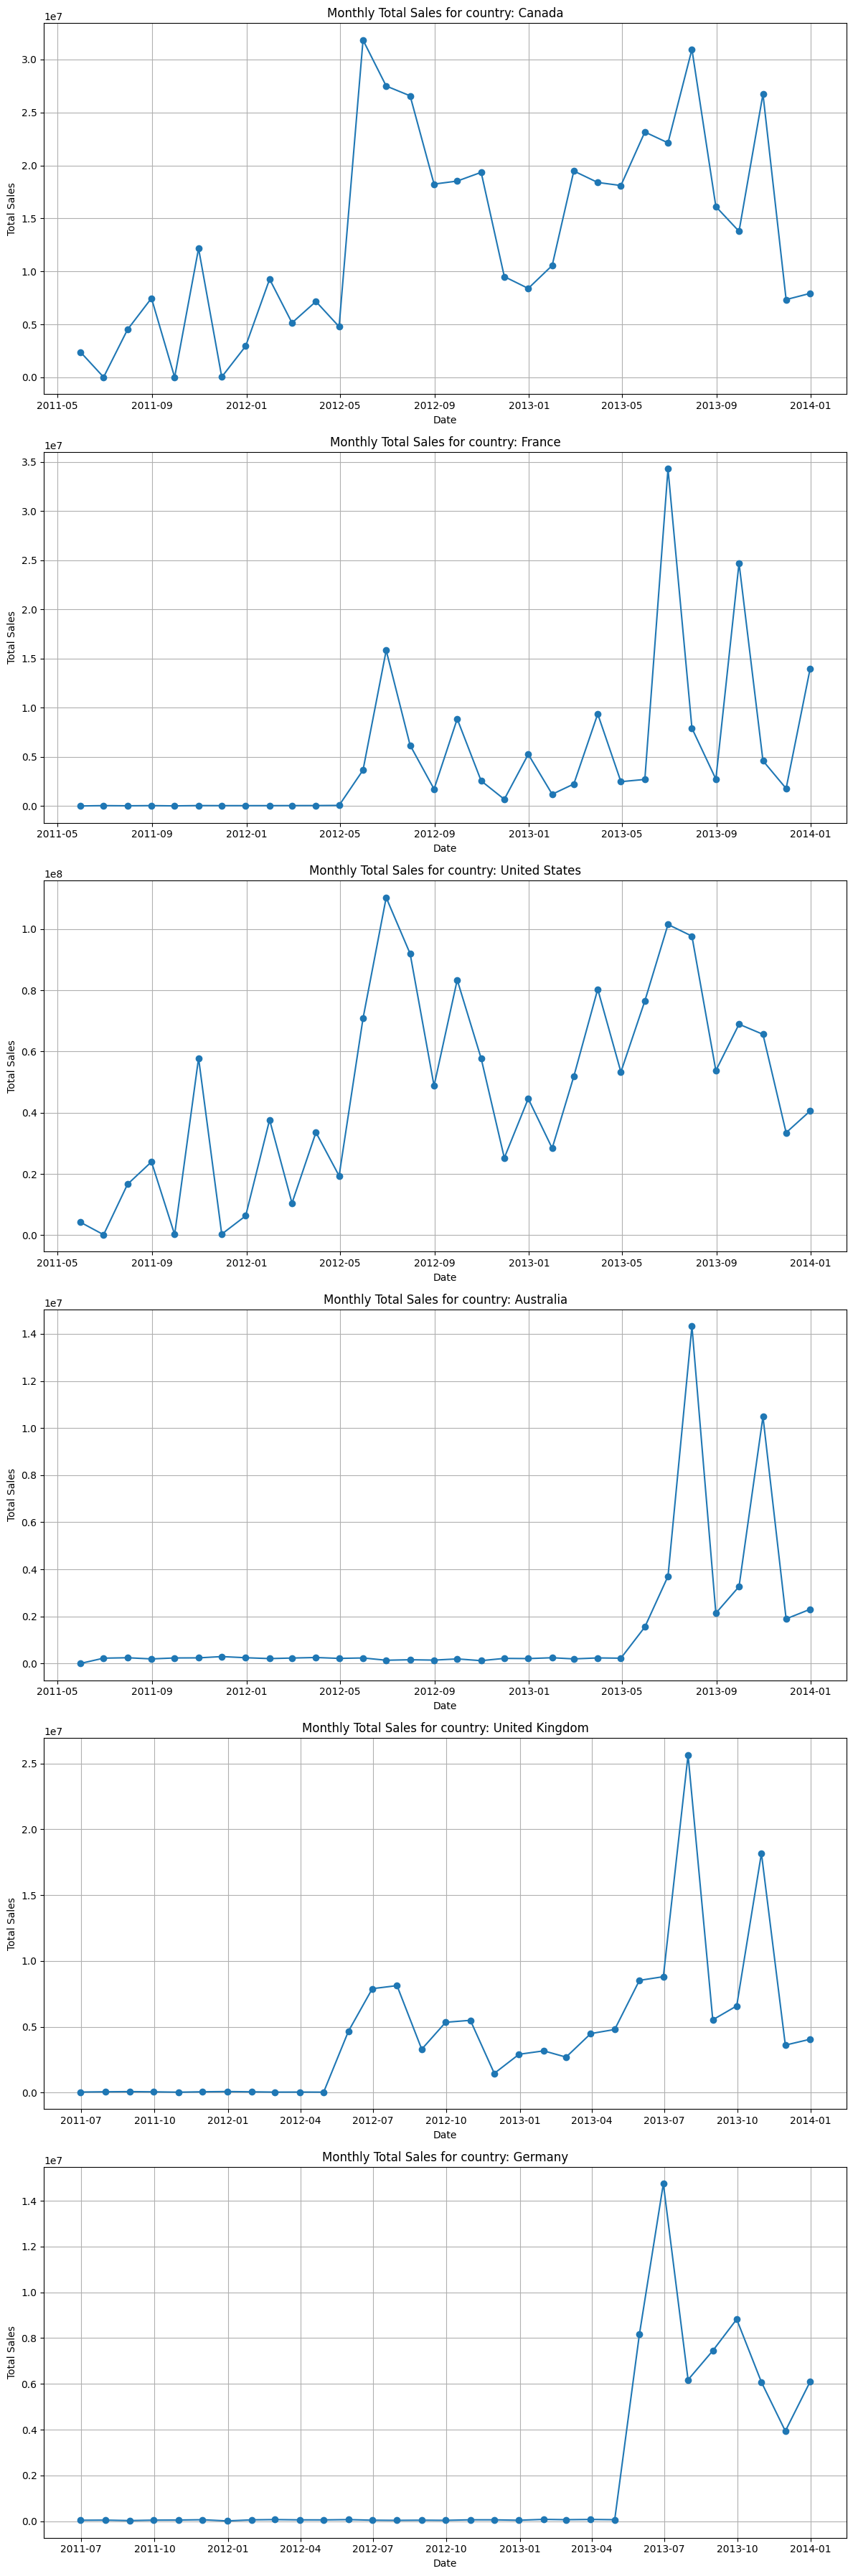

In [164]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [165]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))


# Perform ADF test
for (country, data) in train_data.items():
    print(f'{country}')
    adf_test(data)

Canada
ADF Statistic: -2.232210322016798
p-value: 0.19476330923267954
Critical Value (1%): -3.711
Critical Value (5%): -2.981
Critical Value (10%): -2.630
France
ADF Statistic: -1.799858009298236
p-value: 0.3805321903277764
Critical Value (1%): -3.689
Critical Value (5%): -2.972
Critical Value (10%): -2.625
United States
ADF Statistic: -3.0274174450675675
p-value: 0.0324120809442737
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
Australia
ADF Statistic: -0.9097581226221825
p-value: 0.7847419443922327
Critical Value (1%): -3.679
Critical Value (5%): -2.968
Critical Value (10%): -2.623
United Kingdom
ADF Statistic: -3.5649630081068024
p-value: 0.006467290018114363
Critical Value (1%): -3.670
Critical Value (5%): -2.964
Critical Value (10%): -2.621
Germany
ADF Statistic: 4.23638260261955
p-value: 1.0
Critical Value (1%): -3.738
Critical Value (5%): -2.992
Critical Value (10%): -2.636


In [160]:
# #return p value
# def calculate_p_value(data):
#     """
#     If p-value > 0.05: The time series is non-stationary.
#     If p-value ≤ 0.05: The time series is stationary.
#     """
#     result = adfuller(data)
#     return result[1]



# #Make the time series stationary
# def make_stationary(combined_data, train_data, test_data):
#     """
#     Make train_data stationary and apply the same differencing logic to test_data,
#     ensuring consistent transformation without combining datasets.
#     """
#     differencing_info = {}  # Store number of differences for each country
#     stationary_combined_data = {}
#     stationary_train_data = {}
#     stationary_test_data = {}

#     for country, train_series in train_data.items():
#         print(f"\nProcessing country: {country}")
        
#         # Initialize differencing count and check train_data for stationarity
#         differences = 0
#         p_value = calculate_p_value(train_series)
#         current_train_series = train_series

#         # Apply differencing to train_data until stationary
#         while p_value > 0.05:
#             current_train_series = current_train_series.diff().dropna()
#             differences += 1
#             p_value = calculate_p_value(current_train_series)
        
#         # Store stationary train data
#         stationary_train_data[country] = current_train_series
#         differencing_info[country] = differences

#         # Apply the same differencing logic to combined_data and test_data
#         current_test_series = combined_data[country]
#         for _ in range(differences):
#             # Use the last value of train_series for differencing
#             current_test_series = current_test_series.diff().dropna()
            
#         # Store stationary combined data
#         stationary_combined_data[country] = current_test_series
        
        
#         current_test_series = test_data[country]
#         for _ in range(differences):
#             # Use the last value of train_series for differencing
#             current_test_series = current_test_series.diff().dropna()
        
#         # Store stationary test data
#         stationary_test_data[country] = current_test_series

#         print(f"Country: {country} - Stationary after {differences} differences.")

#     return stationary_combined_data, stationary_train_data, stationary_test_data

# # Apply the function to train_data and test_data
# combined_data, train_data, test_data = make_stationary(combined_data, train_data, test_data)


Processing country: Canada
Country: Canada - Stationary after 1 differences.

Processing country: France
Country: France - Stationary after 1 differences.

Processing country: United States
Country: United States - Stationary after 0 differences.

Processing country: Australia
Country: Australia - Stationary after 1 differences.

Processing country: United Kingdom
Country: United Kingdom - Stationary after 0 differences.

Processing country: Germany
Country: Germany - Stationary after 3 differences.


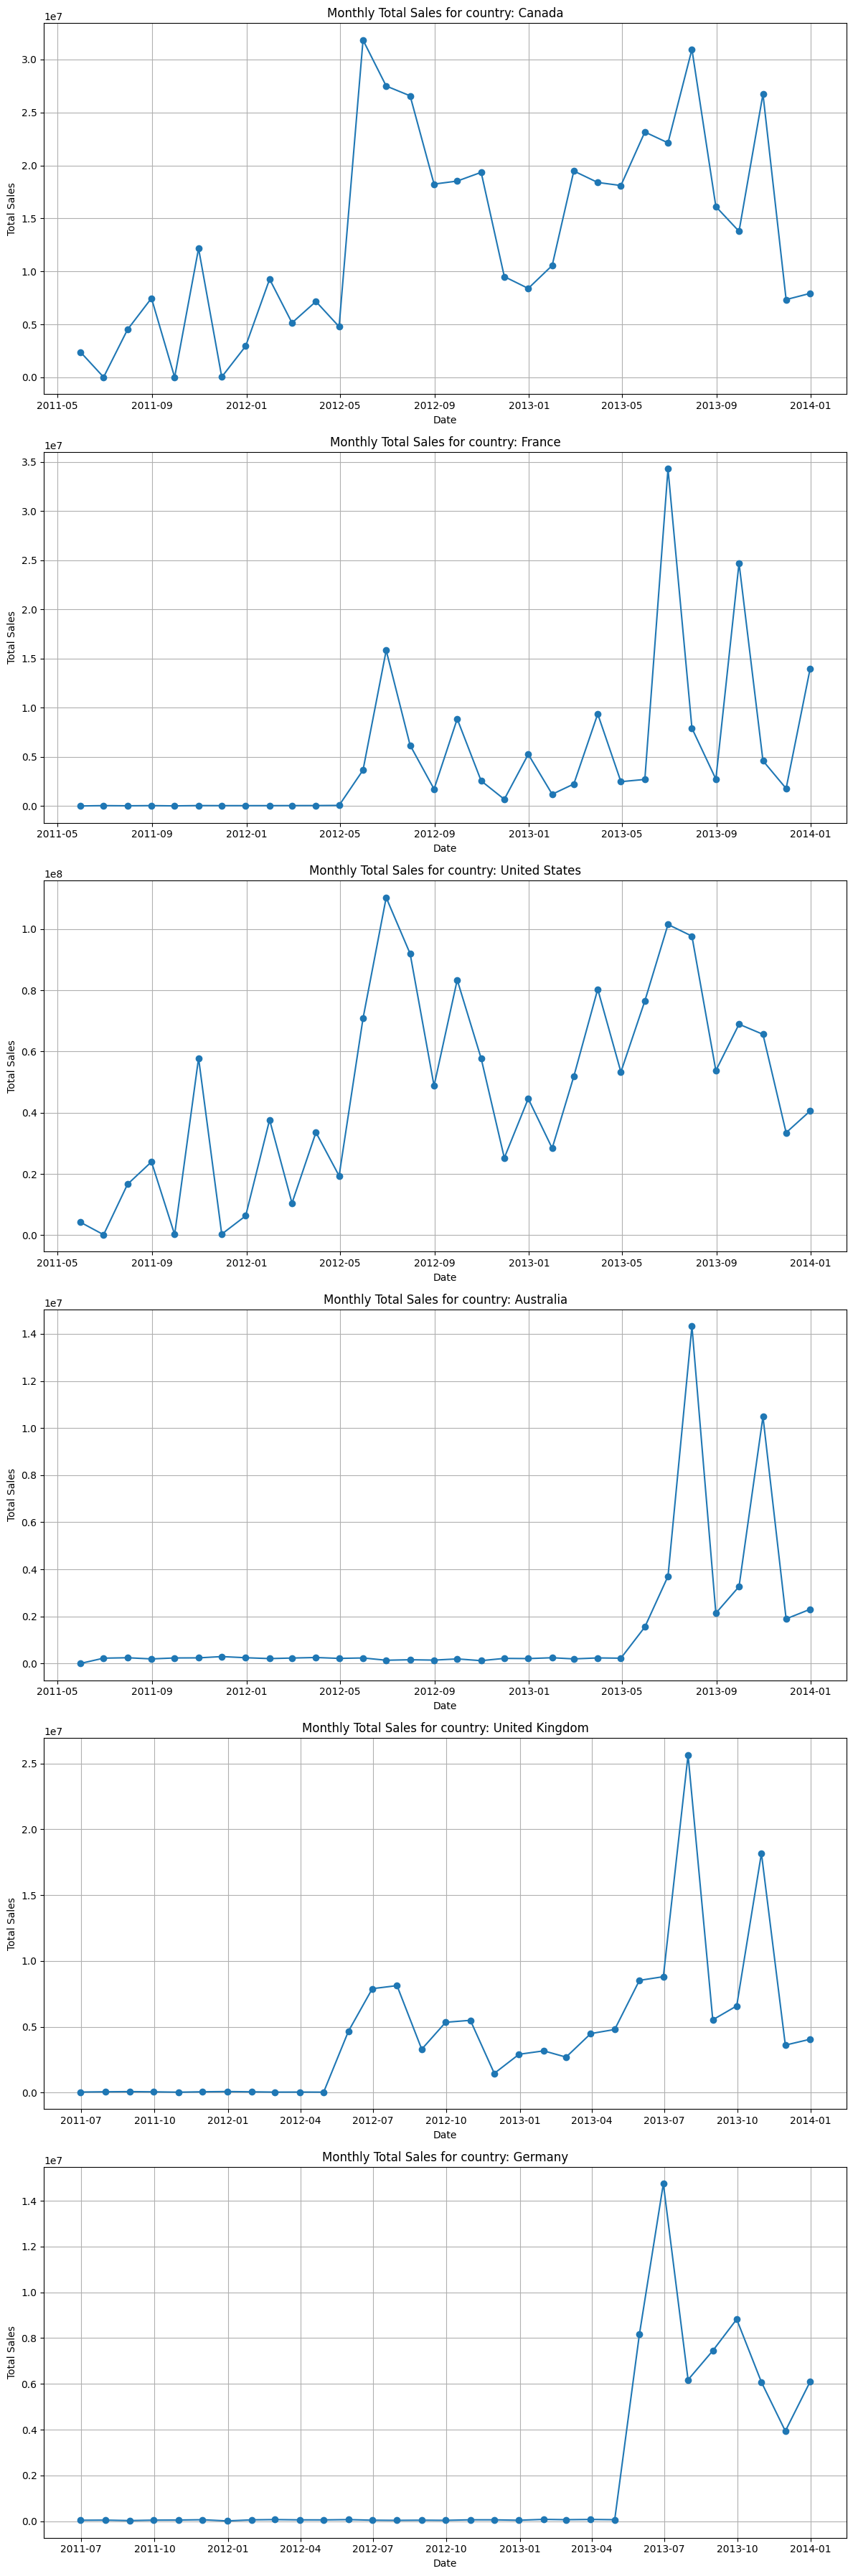

In [166]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## ARIMA

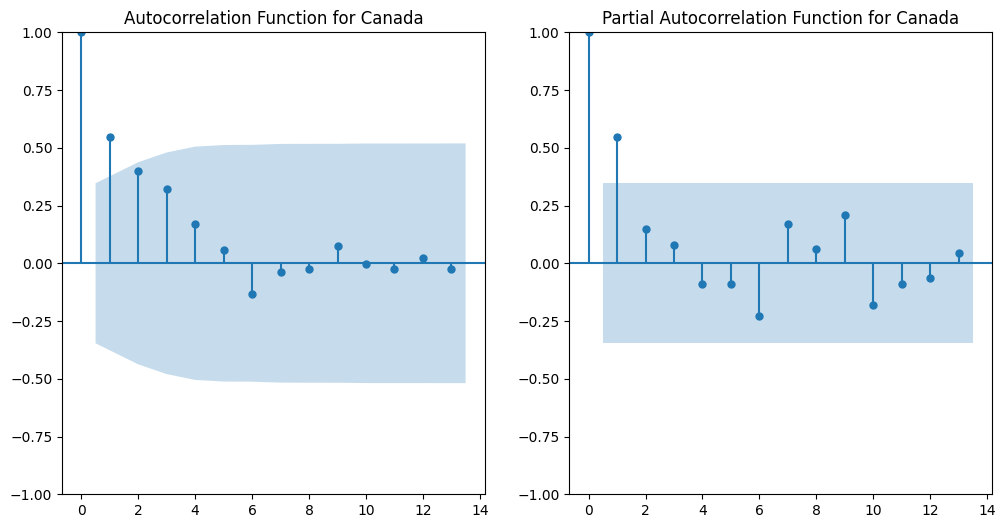

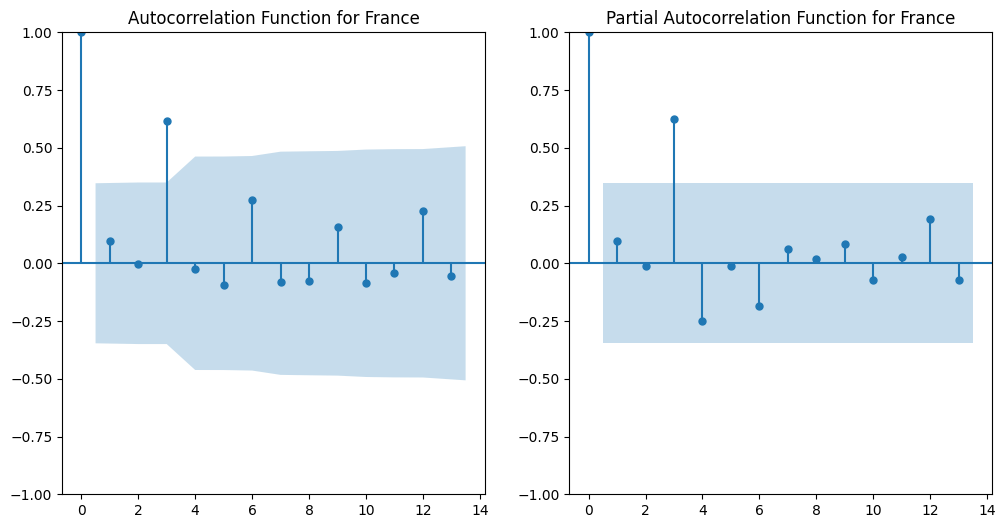

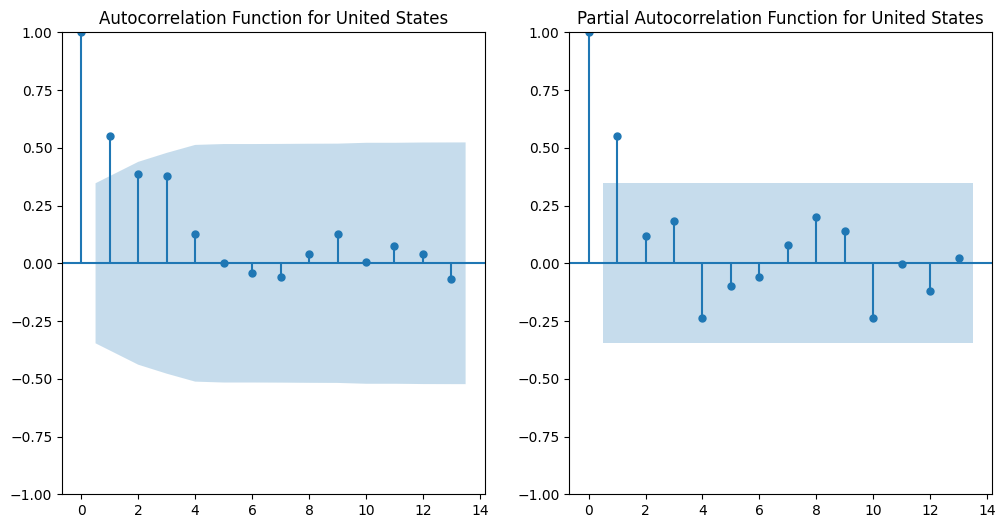

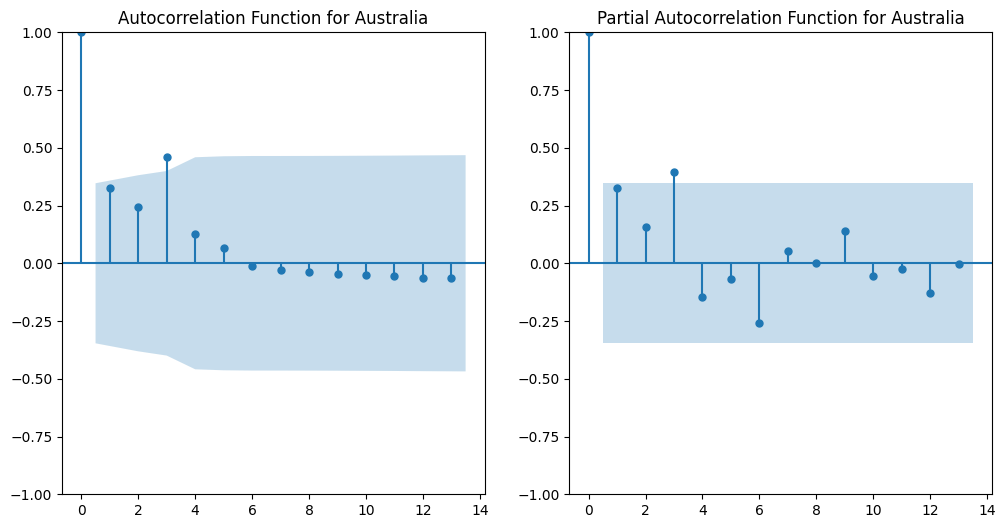

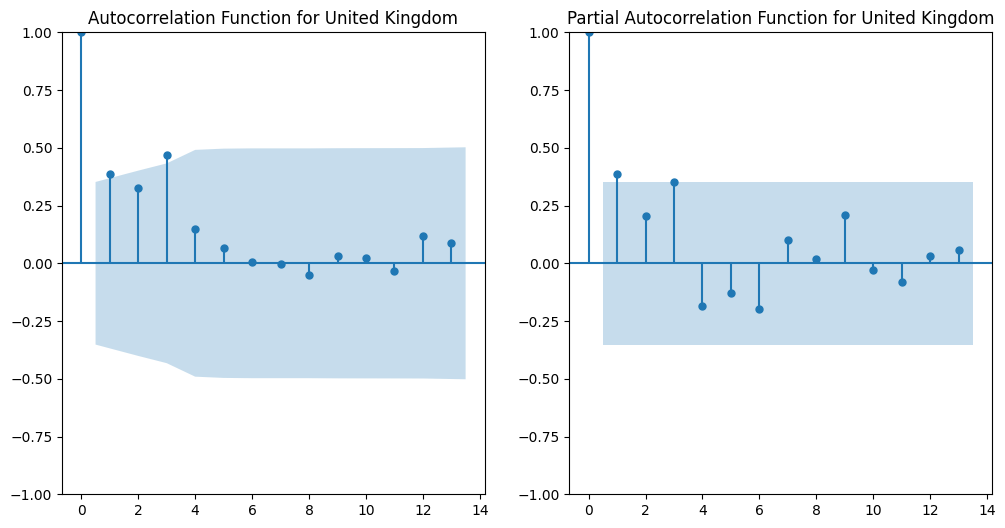

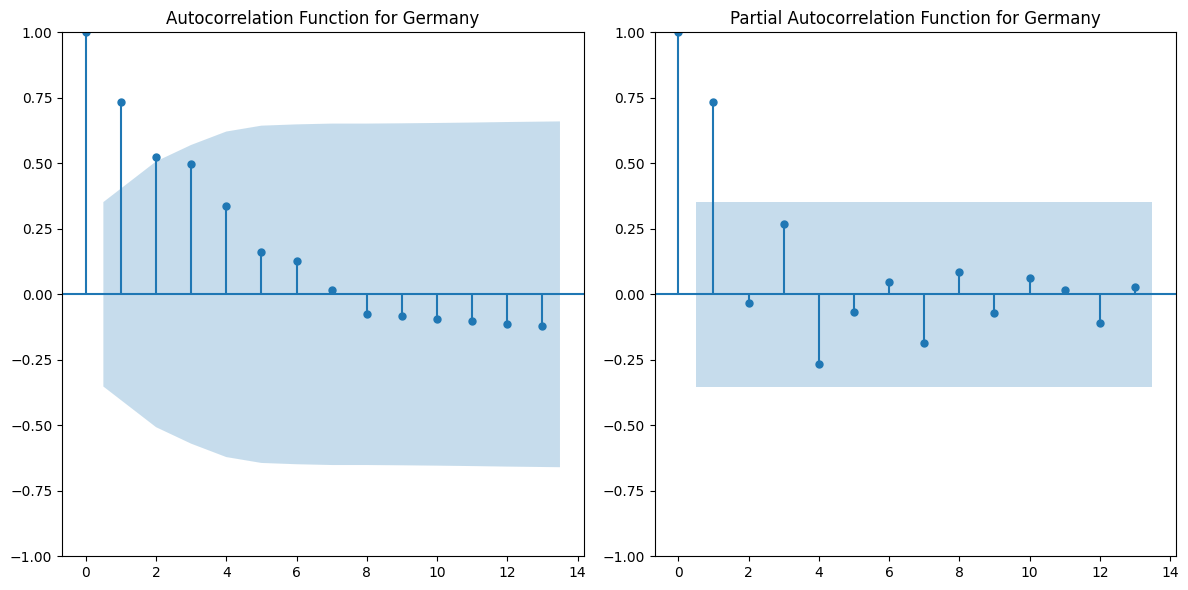

In [167]:
# Define maximum lags (adjust as necessary)
max_lags = 13

# Loop through each country and plot ACF and PACF
for country, monthly_sales in train_data.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {country}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {country}')
    
plt.tight_layout()
plt.show()

In [168]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=False, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1116.423, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1155.755, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1115.503, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1143.520, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1114.016, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1115.385, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1115.614, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1113.637, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1115.821, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1142.020, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1113.429, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1116.143, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1111.731, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1121.420, Time=0.0

In [146]:
countries

['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany']

In [169]:
model_countries = {}

model_countries[countries[0]] = ARIMA(train_data[countries[0]], order=(6, 1, 6))
model_countries[countries[1]] = ARIMA(train_data[countries[1]], order=(2, 1, 3))
model_countries[countries[2]] = ARIMA(train_data[countries[2]], order=(1, 0, 1))
model_countries[countries[3]] = ARIMA(train_data[countries[3]], order=(2, 1, 1))
model_countries[countries[4]] = ARIMA(train_data[countries[4]], order=(3, 0, 3))
model_countries[countries[5]] = ARIMA(train_data[countries[5]], order=(2, 3, 1))

In [170]:
model_fit_countries = {}

for (country, model) in model_countries.items():
    print(country)
    model_fit_countries[country] = model_countries[country].fit()

Canada


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


France
United States
Australia
United Kingdom
Germany


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [171]:
model_fit_countries.items()

dict_items([('Canada', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000002689CFC9730>), ('France', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000002688222B7A0>), ('United States', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000026881901640>), ('Australia', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000026881902FF0>), ('United Kingdom', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000026881903500>), ('Germany', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000026882294CE0>)])

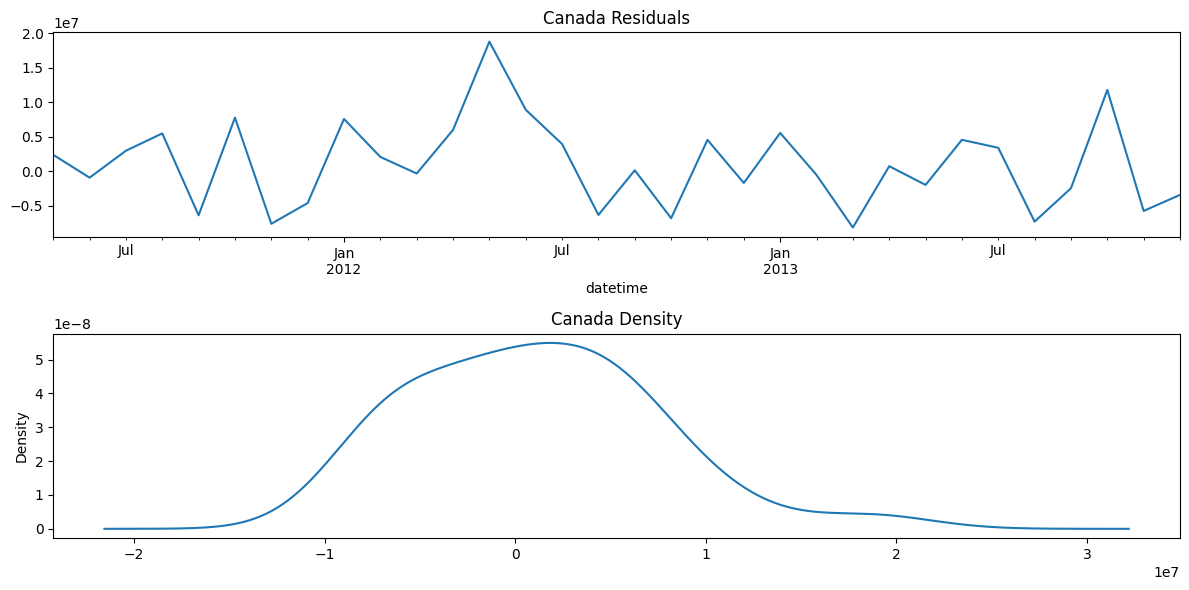

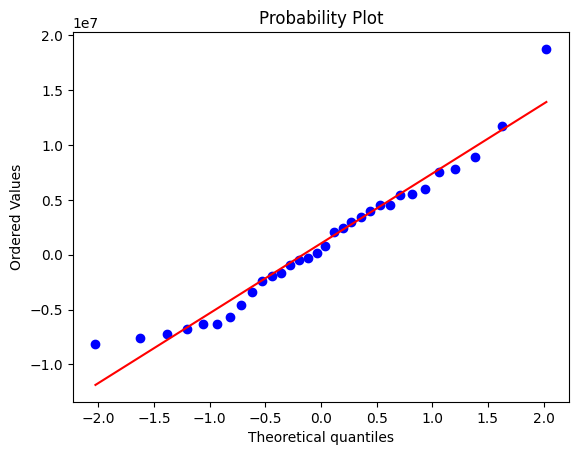

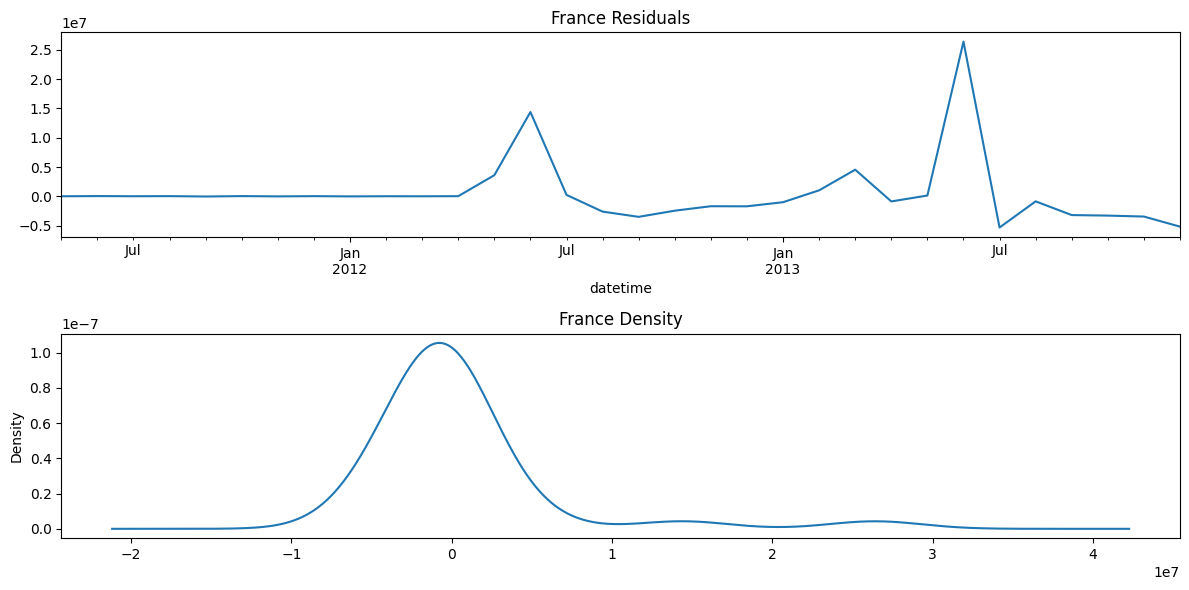

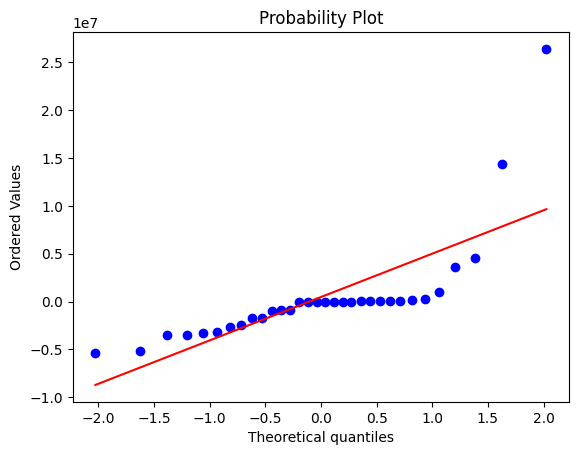

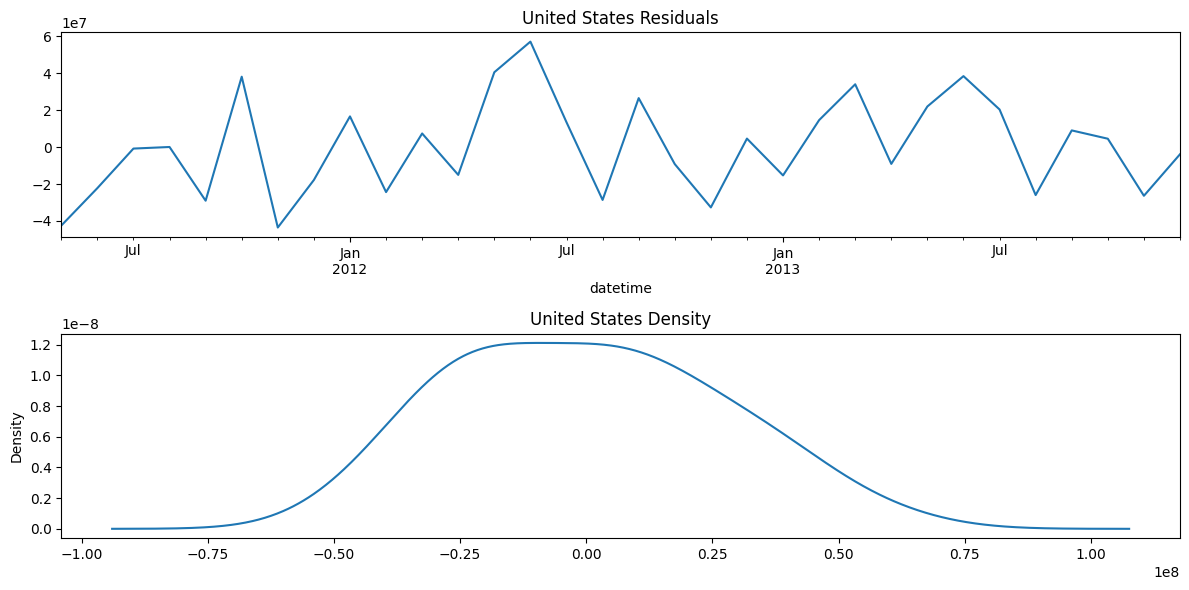

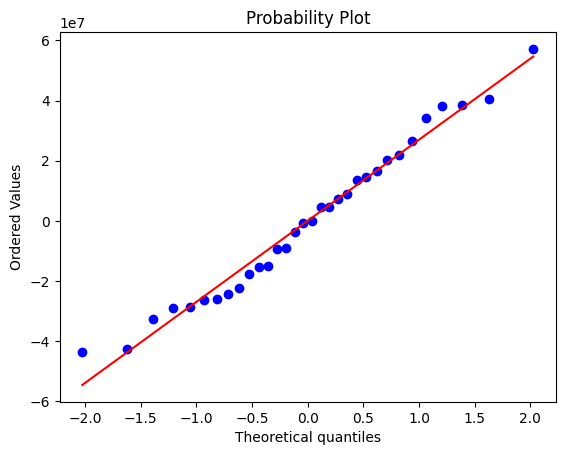

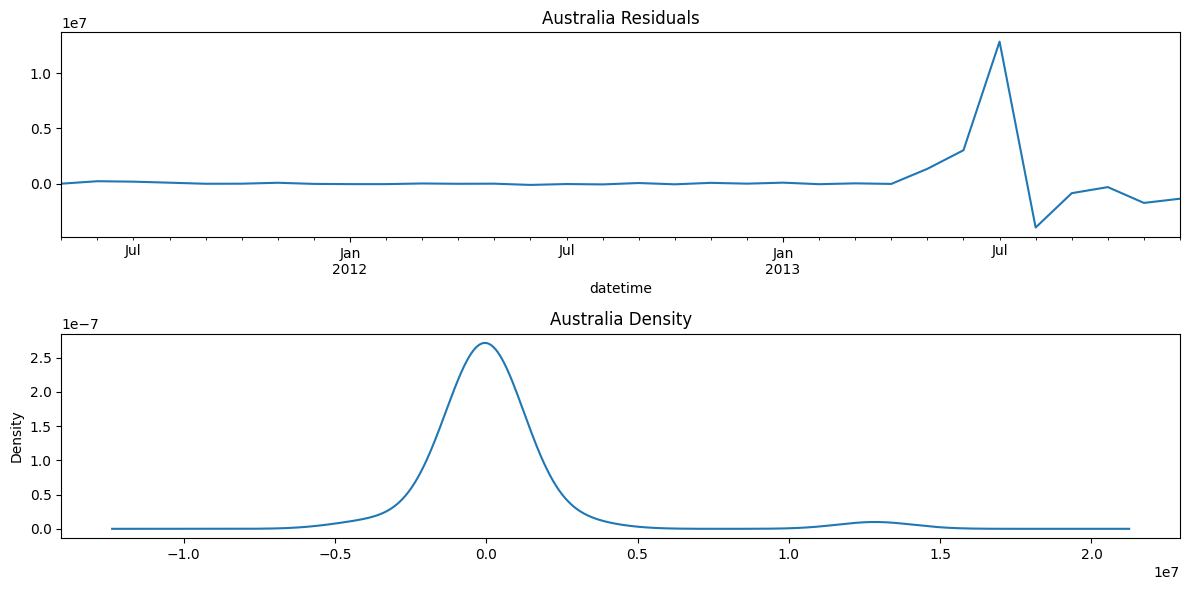

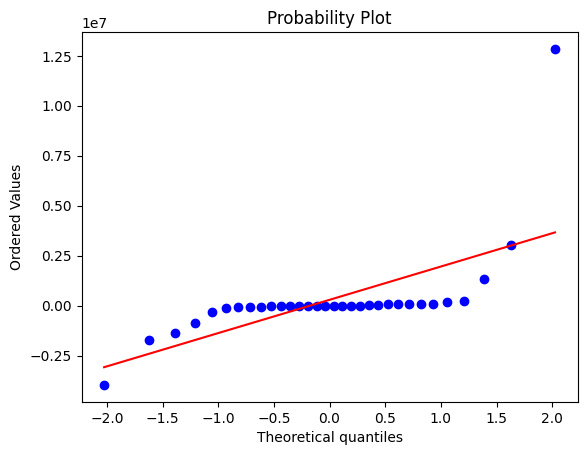

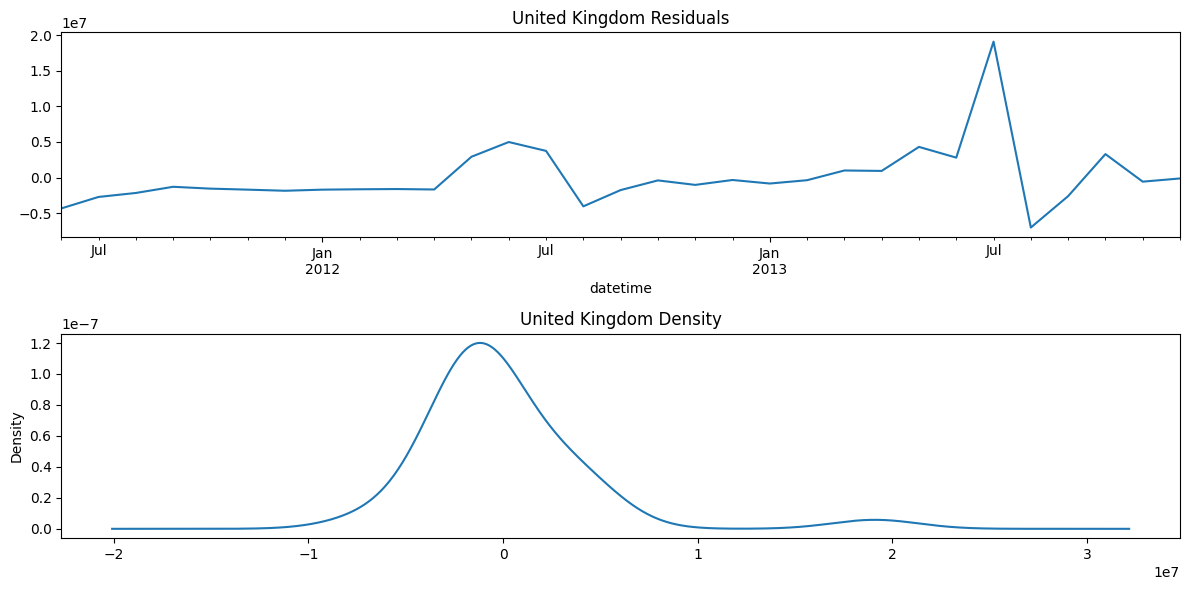

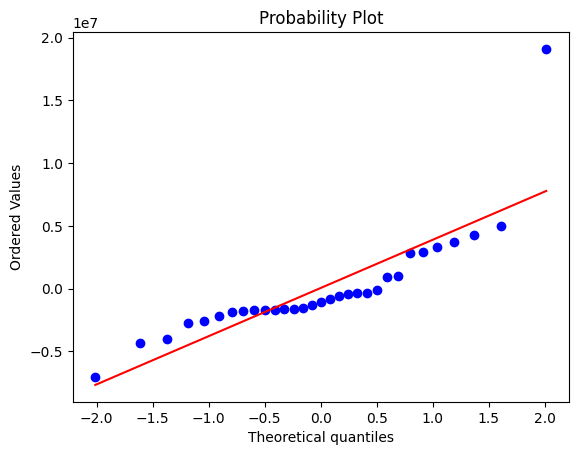

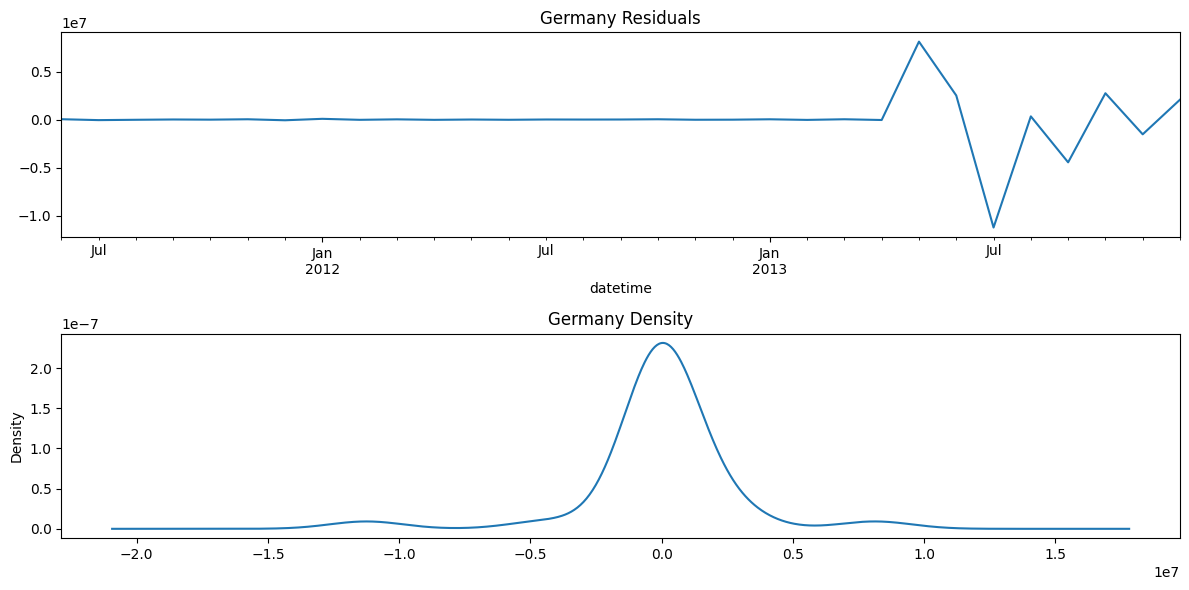

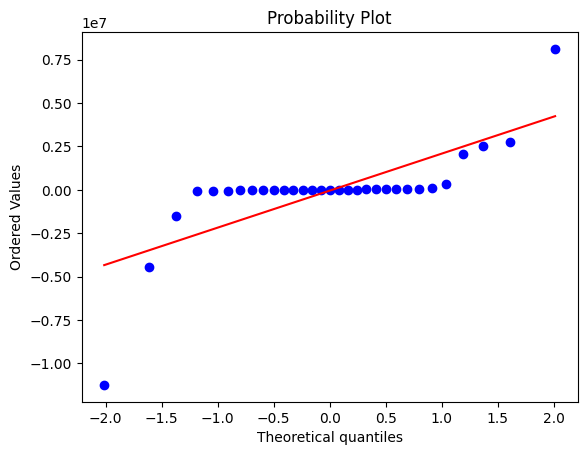

In [172]:
for (country, model) in model_fit_countries.items():
    # Plot residuals
    residuals = model.resid

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    residuals.plot(title=country + " Residuals", ax=plt.gca())

    plt.subplot(212)
    residuals.plot(kind='kde', title=country + ' Density', ax=plt.gca())

    plt.tight_layout()
    plt.show()

    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()


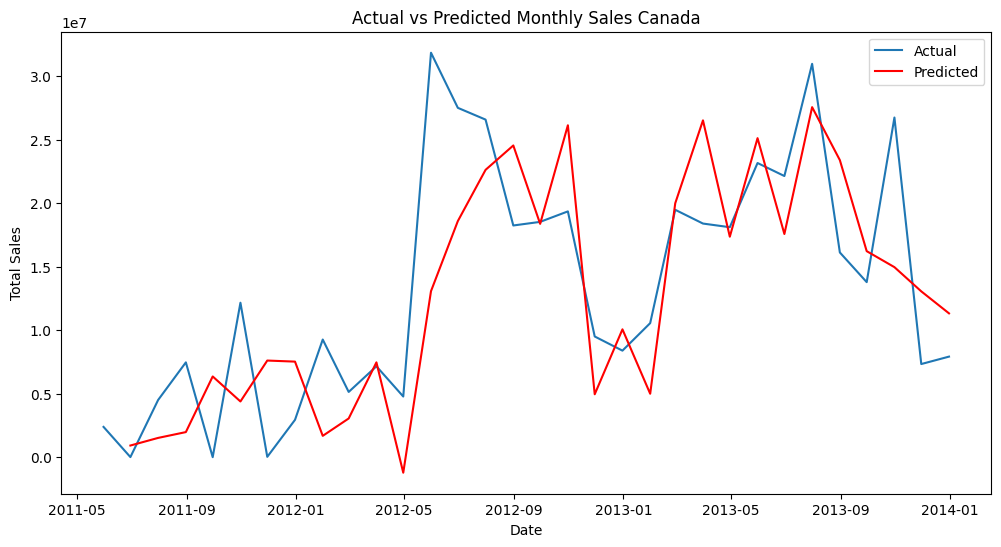

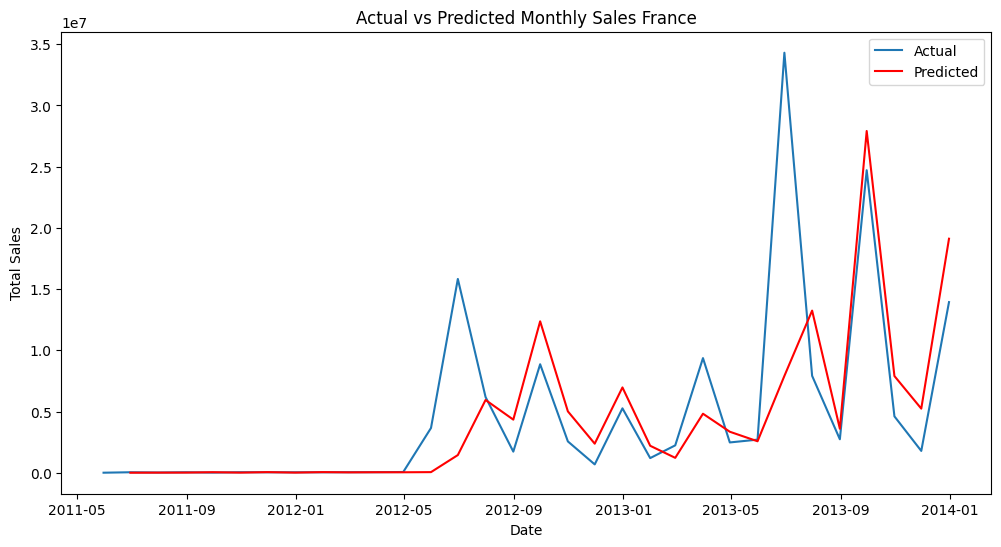

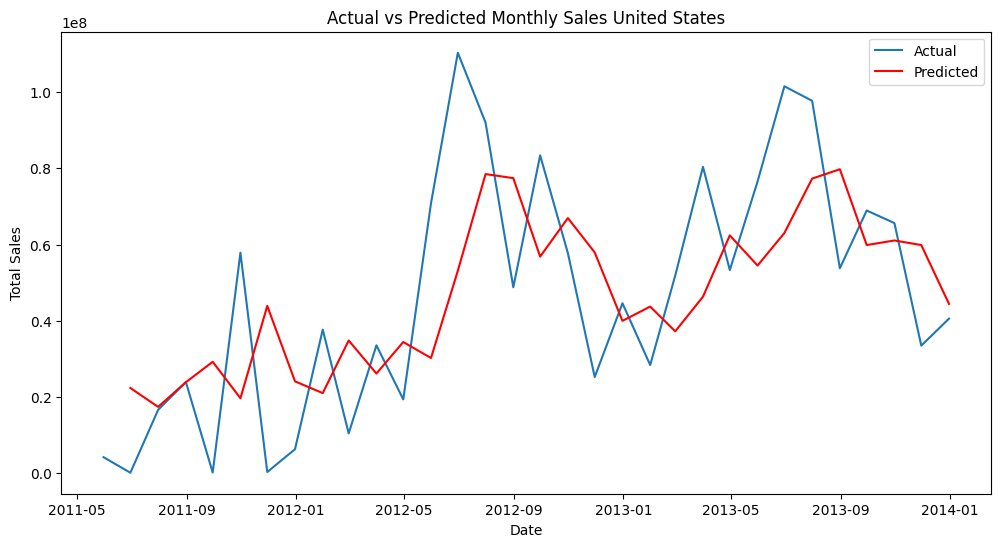

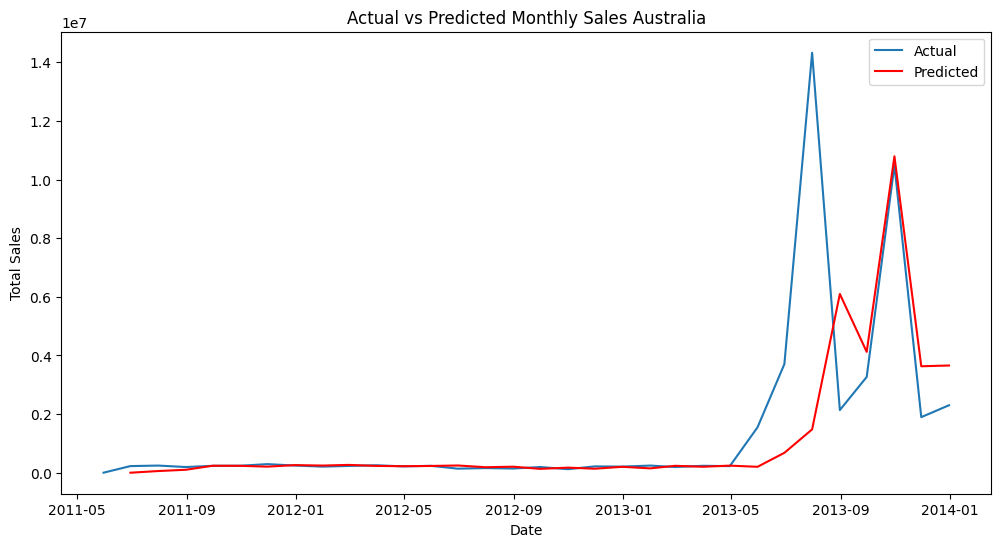

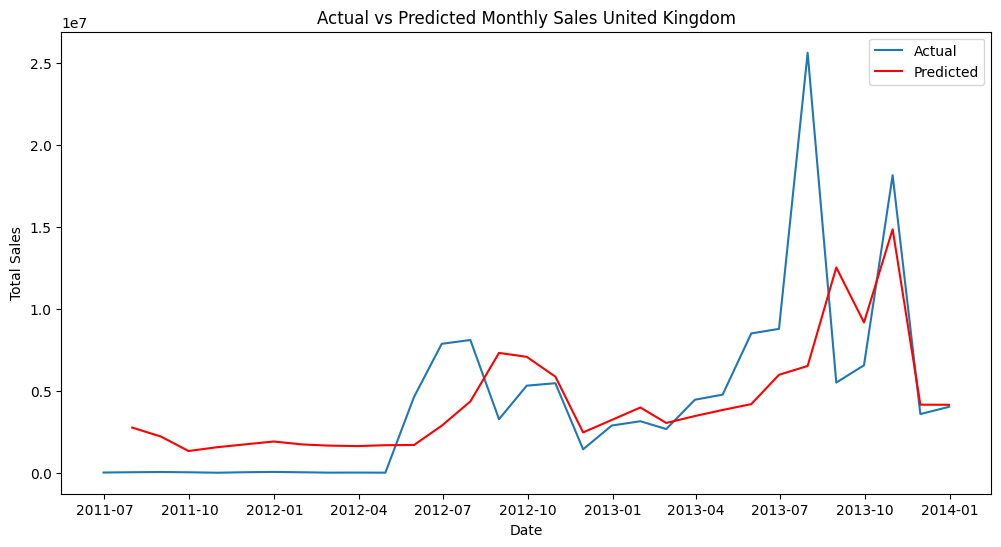

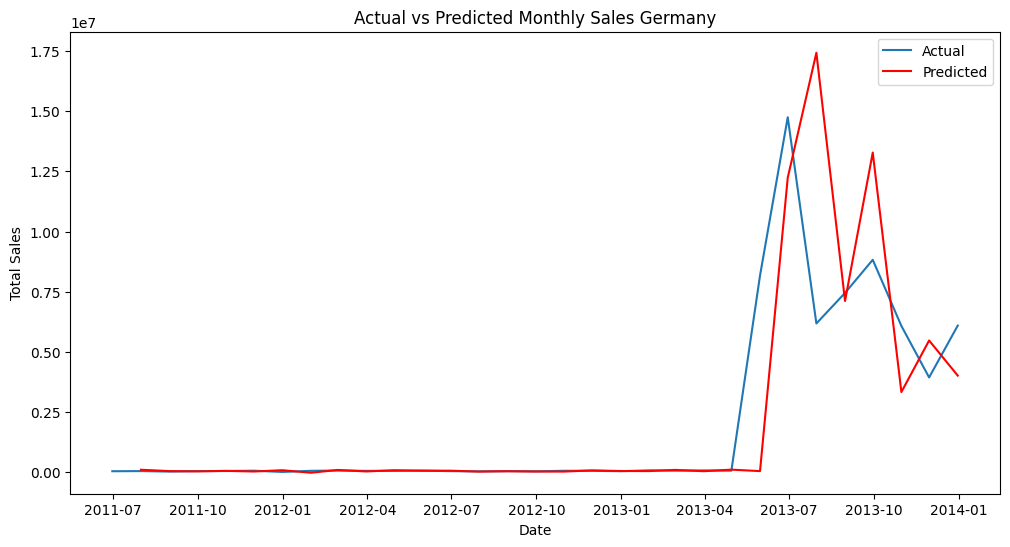

In [173]:
for (country, model) in model_fit_countries.items():
    # In-sample prediction
    predictions = model.predict(start=train_data[country].index[1], end=train_data[country].index[-1], typ='levels')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[country], label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title('Actual vs Predicted Monthly Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


In [176]:
last_date = train_data[countries[0]].index[-1]
last_date

Timestamp('2013-12-31 00:00:00')

C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\1131501488.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


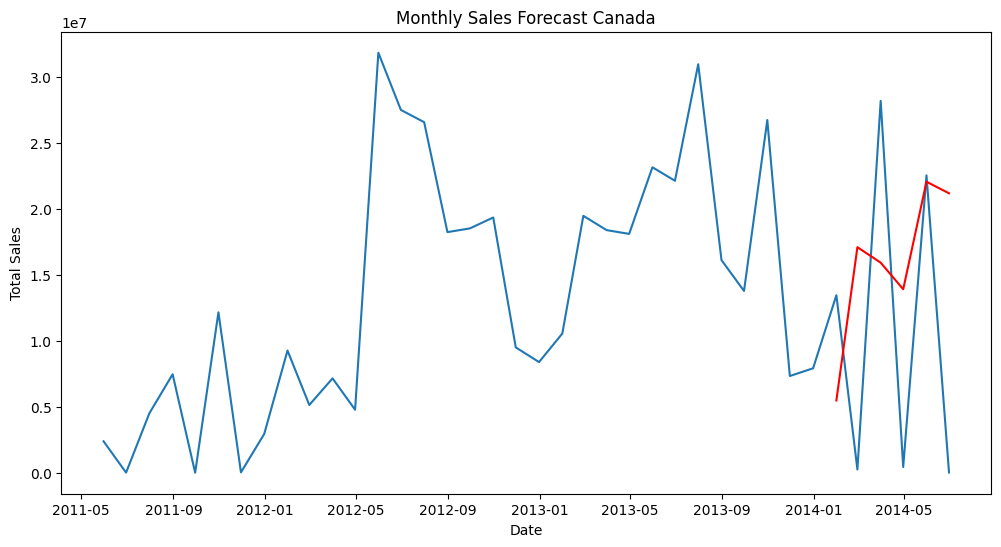

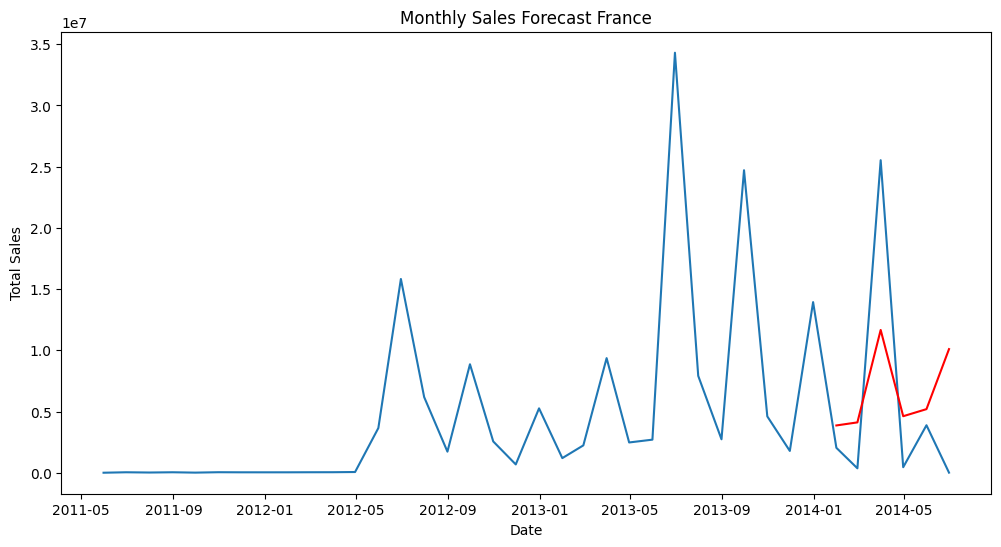

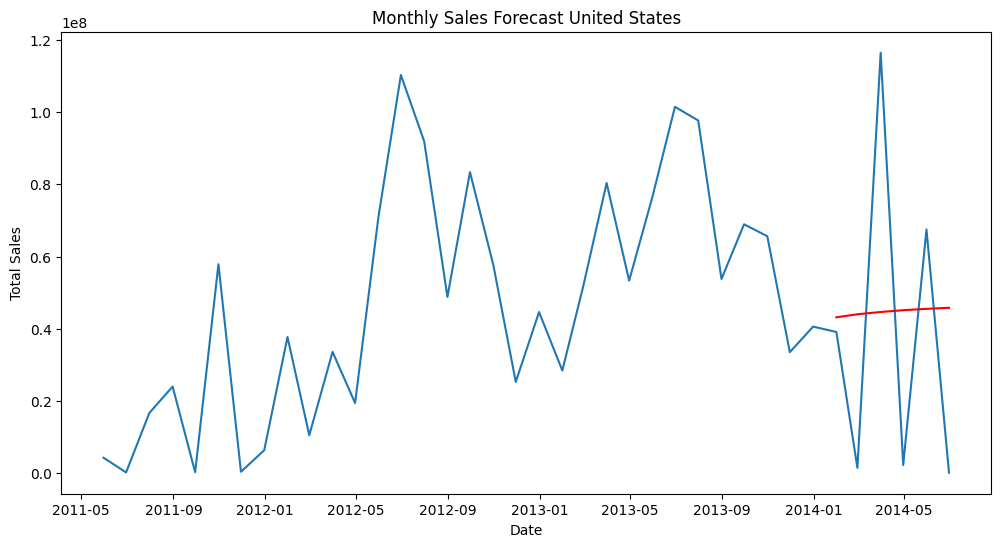

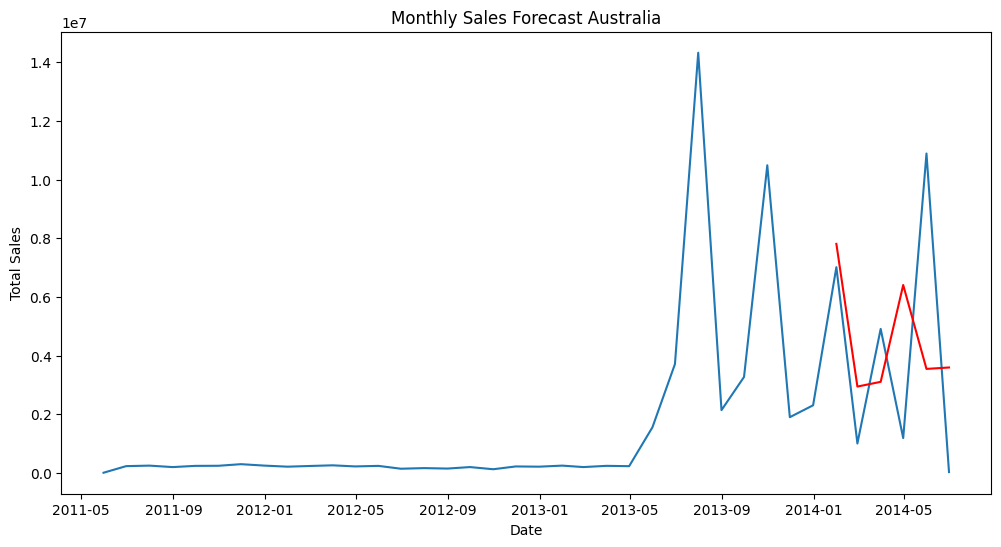

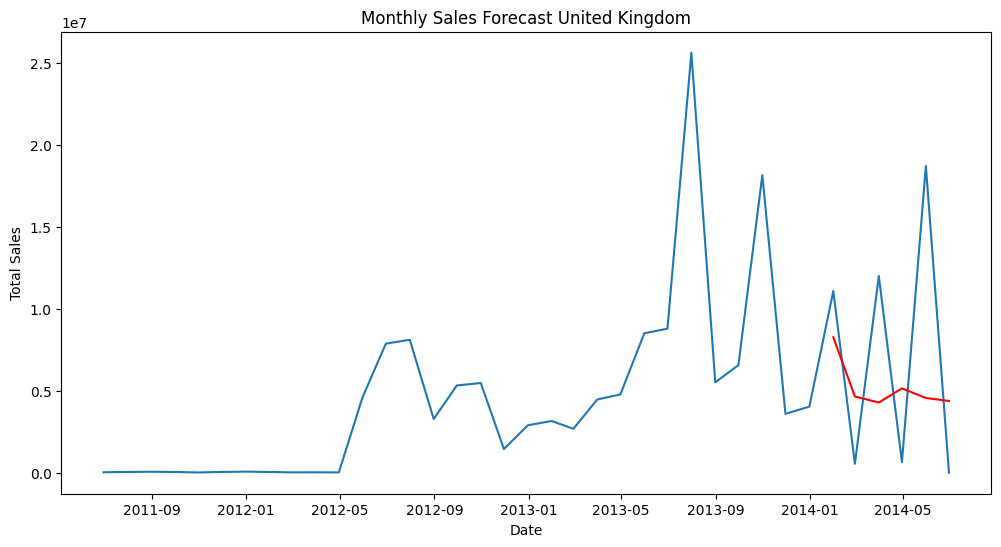

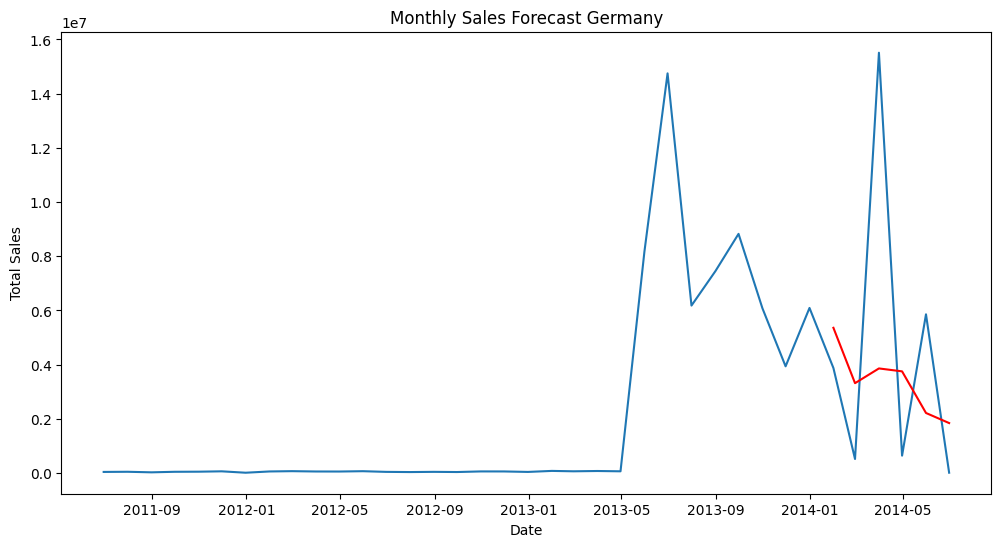

In [ ]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')


In [87]:
# for (country, model) in model_fit_countries.items():
#     # Combine historical and forecast data
#     combined = pd.concat([monthly_sales_by_country[country], forecast_series], axis=0)

#     # Plot combined data
#     plt.figure(figsize=(12, 6))
#     plt.plot(combined, label='Combined Data')
#     plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
#     plt.title('Historical and Forecasted Sales ' + country)
#     plt.xlabel('Date')
#     plt.ylabel('Total Sales')
#     plt.legend()
#     plt.show()


## SARIMA (no significant seasonality was detected in the data.)

In [88]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=True, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1082.750, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1082.549, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1079.950, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1079.044, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1080.562, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1079.893, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1081.215, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1081.339, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1077.170, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1079.051, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1079.343, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1077.983, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1079.489, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit tim

## Machine Learning

In [89]:
# Resample 'TotalDue' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

In [90]:
combined_data.keys()

dict_keys(['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany'])

In [91]:
def add_lag(data, lags=3):
    lagged_data = {}  # To store the lagged DataFrames

    for country, series in data.items():
        print(f"Processing country: {country}")
        
        # Convert Series to DataFrame
        df = series.to_frame(name='sales')  # 'sales' becomes the column name
        
        # Add lag features
        for lag in range(1, lags + 1):
            df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
        
        # Drop NaN rows caused by lagging
        df = df.dropna()

        # Save the processed DataFrame
        lagged_data[country] = df
        
        # Display first rows for validation
        print(type(lagged_data[country]))
        
    
    return lagged_data

In [92]:
lagged_combined_data = add_lag(combined_data, 3)

Processing country: Canada
<class 'pandas.core.frame.DataFrame'>
Processing country: France
<class 'pandas.core.frame.DataFrame'>
Processing country: United States
<class 'pandas.core.frame.DataFrame'>
Processing country: Australia
<class 'pandas.core.frame.DataFrame'>
Processing country: United Kingdom
<class 'pandas.core.frame.DataFrame'>
Processing country: Germany
<class 'pandas.core.frame.DataFrame'>


In [93]:
def split_data(lagged_combined_data):
    lagged_train_data = {}
    lagged_test_data = {}
    
    for country, data in lagged_combined_data.items():
        lagged_train_data[country], lagged_test_data[country] = data[:-6], data[-6:]
        print(type(data))
        
    return lagged_train_data, lagged_test_data

In [94]:
lagged_train_data, lagged_test_data = split_data(lagged_combined_data)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [95]:
lagged_train_data

{'Canada':                    sales   sales_lag_1   sales_lag_2   sales_lag_3
 datetime                                                          
 2011-08-31  7.471918e+06  4.512899e+06  2.031782e+04  2.395443e+06
 2011-09-30  1.318235e+04  7.471918e+06  4.512899e+06  2.031782e+04
 2011-10-31  1.216474e+07  1.318235e+04  7.471918e+06  4.512899e+06
 2011-11-30  4.008776e+04  1.216474e+07  1.318235e+04  7.471918e+06
 2011-12-31  2.951436e+06  4.008776e+04  1.216474e+07  1.318235e+04
 2012-01-31  9.267895e+06  2.951436e+06  4.008776e+04  1.216474e+07
 2012-02-29  5.144809e+06  9.267895e+06  2.951436e+06  4.008776e+04
 2012-03-31  7.162063e+06  5.144809e+06  9.267895e+06  2.951436e+06
 2012-04-30  4.784907e+06  7.162063e+06  5.144809e+06  9.267895e+06
 2012-05-31  3.182959e+07  4.784907e+06  7.162063e+06  5.144809e+06
 2012-06-30  2.749437e+07  3.182959e+07  4.784907e+06  7.162063e+06
 2012-07-31  2.656807e+07  2.749437e+07  3.182959e+07  4.784907e+06
 2012-08-31  1.823936e+07  2.656807e+0

In [96]:
print(lagged_test_data.values())

dict_values([                   sales   sales_lag_1   sales_lag_2   sales_lag_3
datetime                                                          
2014-01-31  1.346066e+07  7.924098e+06  7.339794e+06  2.673192e+07
2014-02-28  2.559653e+05  1.346066e+07  7.924098e+06  7.339794e+06
2014-03-31  2.818234e+07  2.559653e+05  1.346066e+07  7.924098e+06
2014-04-30  4.437361e+05  2.818234e+07  2.559653e+05  1.346066e+07
2014-05-31  2.253944e+07  4.437361e+05  2.818234e+07  2.559653e+05
2014-06-30  3.117614e+04  2.253944e+07  4.437361e+05  2.818234e+07,                    sales   sales_lag_1   sales_lag_2   sales_lag_3
datetime                                                          
2014-01-31  2.037807e+06  1.393636e+07  1.782839e+06  4.605093e+06
2014-02-28  3.638423e+05  2.037807e+06  1.393636e+07  1.782839e+06
2014-03-31  2.552732e+07  3.638423e+05  2.037807e+06  1.393636e+07
2014-04-30  4.535782e+05  2.552732e+07  3.638423e+05  2.037807e+06
2014-05-31  3.881348e+06  4.535782e+05  2.552732

In [97]:
def train_stacking_model(data):
    trained_models = {}
    scalers_X = {}

    for country, df in data.items():
        print(f"Training Stacking model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features only
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # Initialize base models
        lr = LinearRegression()
        xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Initialize stacking regressor
        stacking_model = StackingRegressor(
            estimators=[
                ('lr', lr),      # Linear Regression
                ('xgb', xgb)     # XGBoost
            ],
            final_estimator=LinearRegression()  # Meta-model
        )

        # Leave-One-Out Cross-Validation (LOOCV)
        loo = LeaveOneOut()
        y_preds = []
        y_actuals = []

        for train_index, test_index in loo.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train and predict with stacking model
            stacking_model.fit(X_train, y_train)
            y_pred = stacking_model.predict(X_test)

            y_preds.append(y_pred[0])
            y_actuals.append(y_test)

        # Compute LOOCV RMSE
        rmse = np.sqrt(mean_squared_error(y_actuals, y_preds))
        print(f"{country} - LOOCV RMSE: {rmse:.2f}")

        # Train on full data
        stacking_model.fit(X_scaled, y)

        # Save model and scaler
        trained_models[country] = stacking_model
        scalers_X[country] = scaler_X

    return trained_models, scalers_X

In [98]:
train_models, scalers_X = train_stacking_model(lagged_train_data)

Training Stacking model for Canada...
Canada - LOOCV RMSE: 9475972.36
Training Stacking model for France...
France - LOOCV RMSE: 6258565.82
Training Stacking model for United States...
United States - LOOCV RMSE: 29556590.71
Training Stacking model for Australia...
Australia - LOOCV RMSE: 5841743.49
Training Stacking model for United Kingdom...
United Kingdom - LOOCV RMSE: 5867883.58
Training Stacking model for Germany...
Germany - LOOCV RMSE: 3583126.23


In [99]:
train_models

{'Canada': StackingRegressor(estimators=[('lr', LinearRegression()),
                               ('xgb',
                                XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             lea

In [100]:
def test_simple_model(trained_models, scalers_X, test_data):
    countries_predict = {}
    
    for country, df in test_data.items():
        print(f"Testing model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features using the saved scaler
        X_scaled = scalers_X[country].transform(X)

        # Predict
        y_pred = trained_models[country].predict(X_scaled)
        y_pred = pd.Series(y_pred, index=df.index)

        # Calculate MSE and RMSE
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Print evaluation metrics
        print(f"{country} - Mean Squared Error (MSE): {mse:.2f}")
        print(f"{country} - Root Mean Squared Error (RMSE): {rmse:.2f}\n")
        
        countries_predict[country] = y_pred
        
    return countries_predict

In [101]:
countries_predict = test_simple_model(train_models, scalers_X, lagged_test_data)

Testing model for Canada...
Canada - Mean Squared Error (MSE): 147763622699396.97
Canada - Root Mean Squared Error (RMSE): 12155806.13

Testing model for France...
France - Mean Squared Error (MSE): 88487166288554.73
France - Root Mean Squared Error (RMSE): 9406761.73

Testing model for United States...
United States - Mean Squared Error (MSE): 2766765494797957.50
United States - Root Mean Squared Error (RMSE): 52600052.23

Testing model for Australia...
Australia - Mean Squared Error (MSE): 25475716139929.05
Australia - Root Mean Squared Error (RMSE): 5047347.44

Testing model for United Kingdom...
United Kingdom - Mean Squared Error (MSE): 57529673243477.91
United Kingdom - Root Mean Squared Error (RMSE): 7584831.79

Testing model for Germany...
Germany - Mean Squared Error (MSE): 38562129483977.45
Germany - Root Mean Squared Error (RMSE): 6209841.34



In [102]:
countries_predict

{'Canada': datetime
 2014-01-31    9.929708e+06
 2014-02-28    1.194685e+07
 2014-03-31    1.382596e+07
 2014-04-30    1.752602e+07
 2014-05-31    1.516259e+07
 2014-06-30    1.363667e+07
 Freq: ME, dtype: float64,
 'France': datetime
 2014-01-31    5.295224e+06
 2014-02-28    3.519906e+06
 2014-03-31    9.838141e+06
 2014-04-30    6.100641e+06
 2014-05-31    2.428183e+06
 2014-06-30    1.518314e+07
 Freq: ME, dtype: float64,
 'United States': datetime
 2014-01-31    5.044447e+07
 2014-02-28    4.697124e+07
 2014-03-31    3.999051e+07
 2014-04-30    6.191658e+07
 2014-05-31    4.009225e+07
 2014-06-30    6.504009e+07
 Freq: ME, dtype: float64,
 'Australia': datetime
 2014-01-31    3.903973e+06
 2014-02-28    3.493071e+06
 2014-03-31    1.211360e+06
 2014-04-30    4.431585e+06
 2014-05-31    1.225830e+06
 2014-06-30    4.434927e+06
 Freq: ME, dtype: float64,
 'United Kingdom': datetime
 2014-01-31    5.099577e+06
 2014-02-28    4.774869e+06
 2014-03-31    4.803164e+06
 2014-04-30    4.8

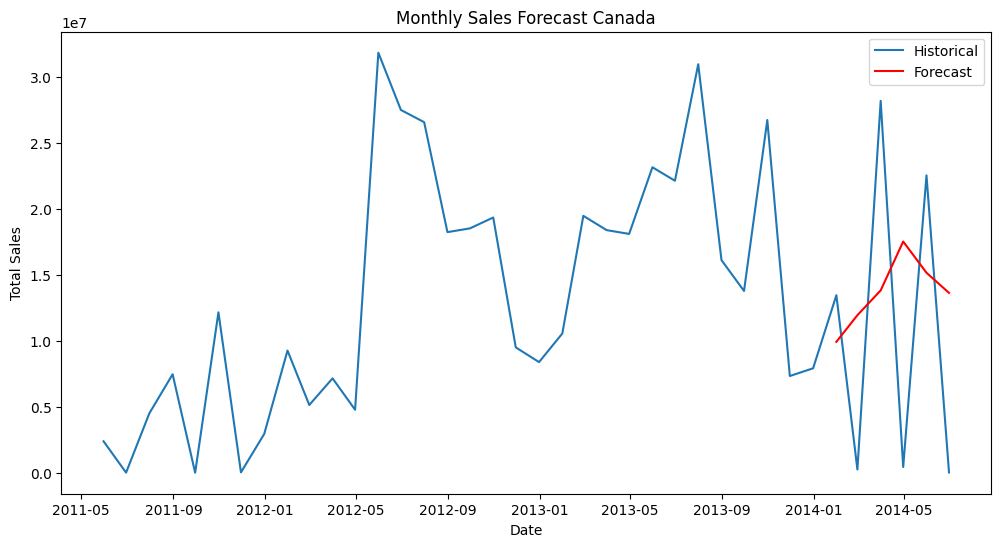

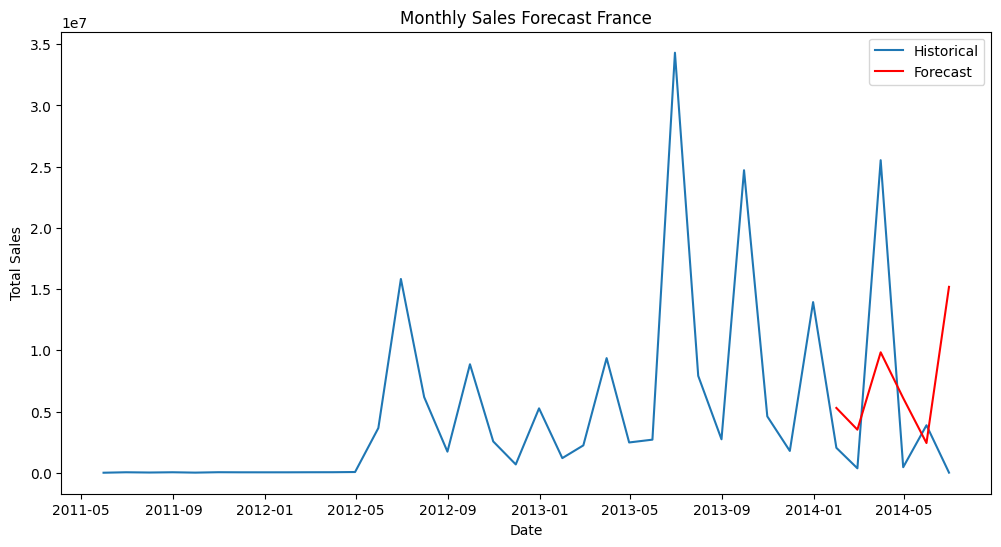

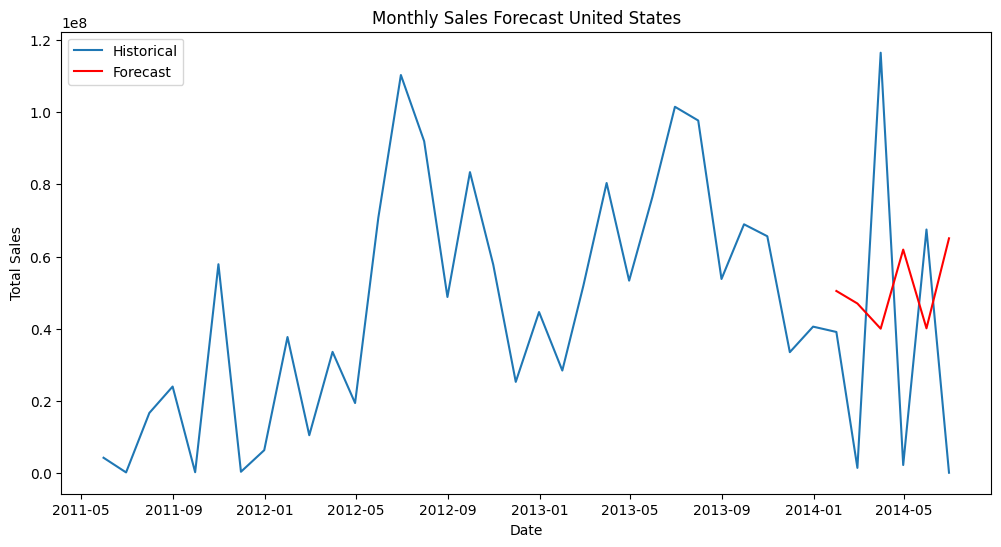

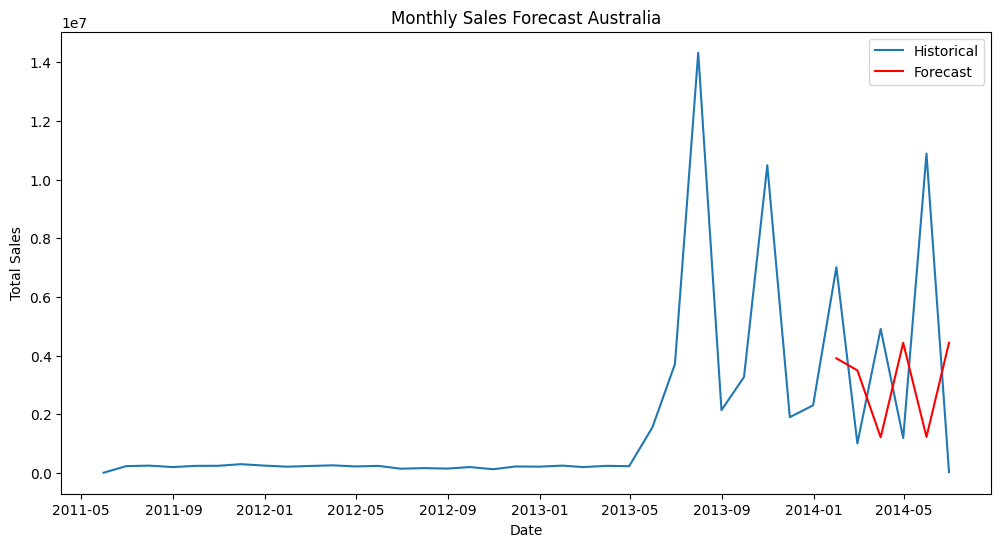

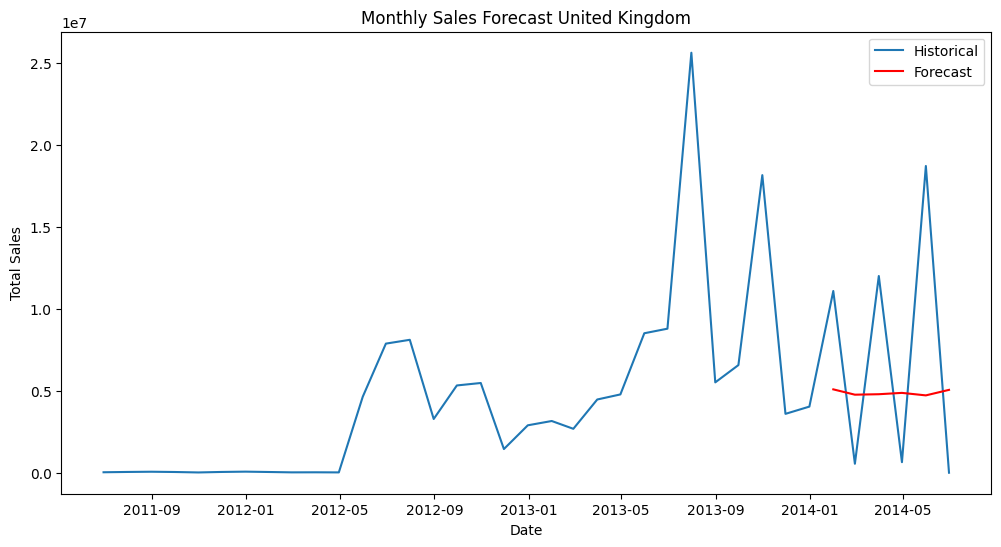

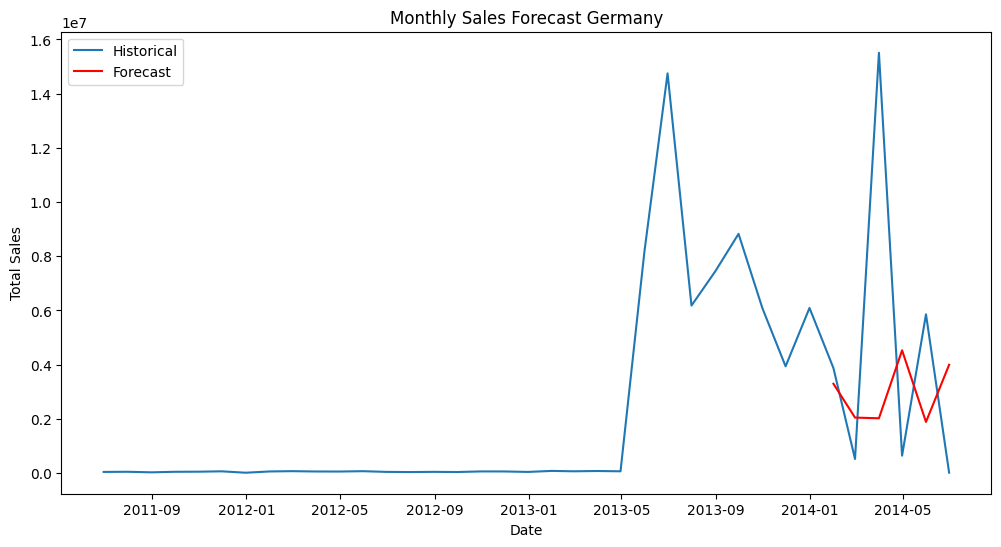

In [103]:
for (country, model) in model_fit_countries.items():

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(countries_predict[country], label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

In [104]:
def forecast_next_months(trained_models, scalers_X, data, months=6):
    future_forecasts = {}

    for country, model in trained_models.items():
        print(f"Forecasting for {country}...")

        # Get the last row of the dataset for lagged features
        last_row = data[country].iloc[-1]
        lag_1, lag_2, lag_3 = last_row['sales_lag_1'], last_row['sales_lag_2'], last_row['sales_lag_3']

        # Start forecasting from the last date in the dataset
        last_date = data[country].index[-1]

        # Generate future dates
        future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]

        # List to store forecasts
        forecasts = []

        for date in future_dates:
            # Create features for the current prediction
            X_new = pd.DataFrame([[lag_1, lag_2, lag_3]], columns=['sales_lag_1', 'sales_lag_2', 'sales_lag_3'])

            # Scale features
            scaler_X = scalers_X[country]
            X_new_scaled = scaler_X.transform(X_new)

            # Predict the next month's sales
            next_sales = model.predict(X_new_scaled)[0]

            # Append prediction to the forecasts
            forecasts.append(next_sales)

            # Update lagged features
            lag_3 = lag_2
            lag_2 = lag_1
            lag_1 = next_sales

        # Convert forecasts to pandas Series with dates as the index
        future_forecasts[country] = pd.Series(data=forecasts, index=future_dates, name='forecast')

    return future_forecasts


In [105]:
future_forecasts = forecast_next_months(train_models, scalers_X, lagged_test_data, 6)
future_forecasts

Forecasting for Canada...
Forecasting for France...
Forecasting for United States...
Forecasting for Australia...
Forecasting for United Kingdom...
Forecasting for Germany...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[

{'Canada': 2014-07-31    1.363667e+07
 2014-08-31    1.523841e+07
 2014-09-30    1.300397e+07
 2014-10-31    1.491535e+07
 2014-11-30    1.313503e+07
 2014-12-31    1.489085e+07
 Freq: ME, Name: forecast, dtype: float64,
 'France': 2014-07-31    1.518314e+07
 2014-08-31    4.236842e+06
 2014-09-30    4.007760e+06
 2014-10-31    1.068022e+07
 2014-11-30    4.927370e+06
 2014-12-31    4.217441e+06
 Freq: ME, Name: forecast, dtype: float64,
 'United States': 2014-07-31    6.504009e+07
 2014-08-31    5.134694e+07
 2014-09-30    5.026904e+07
 2014-10-31    4.946804e+07
 2014-11-30    4.678513e+07
 2014-12-31    5.087355e+07
 Freq: ME, Name: forecast, dtype: float64,
 'Australia': 2014-07-31    4.434927e+06
 2014-08-31    1.673539e+06
 2014-09-30    1.761199e+06
 2014-10-31    2.046758e+06
 2014-11-30    3.449190e+06
 2014-12-31    4.557834e+06
 Freq: ME, Name: forecast, dtype: float64,
 'United Kingdom': 2014-07-31    5.069230e+06
 2014-08-31    4.725545e+06
 2014-09-30    5.106980e+06
 201

C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\1407805102.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


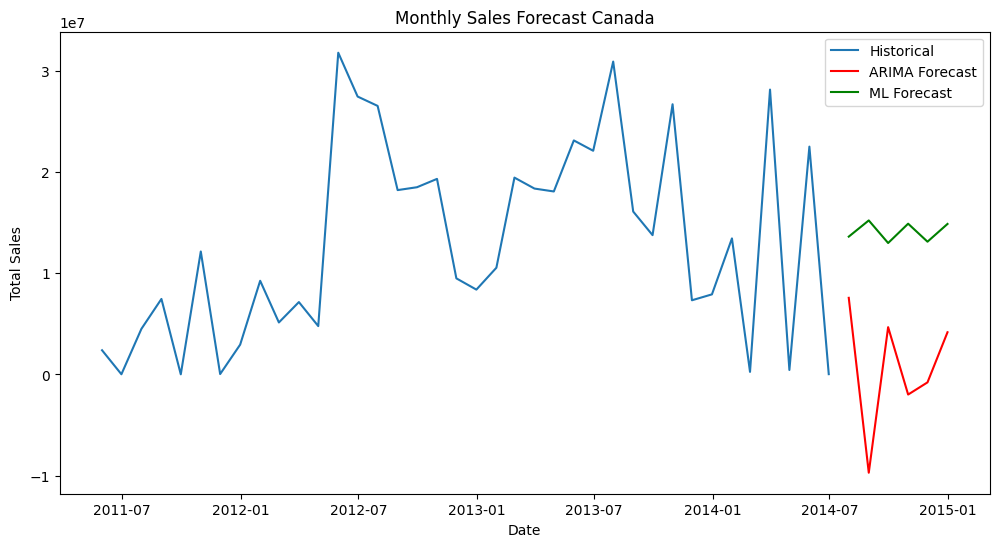

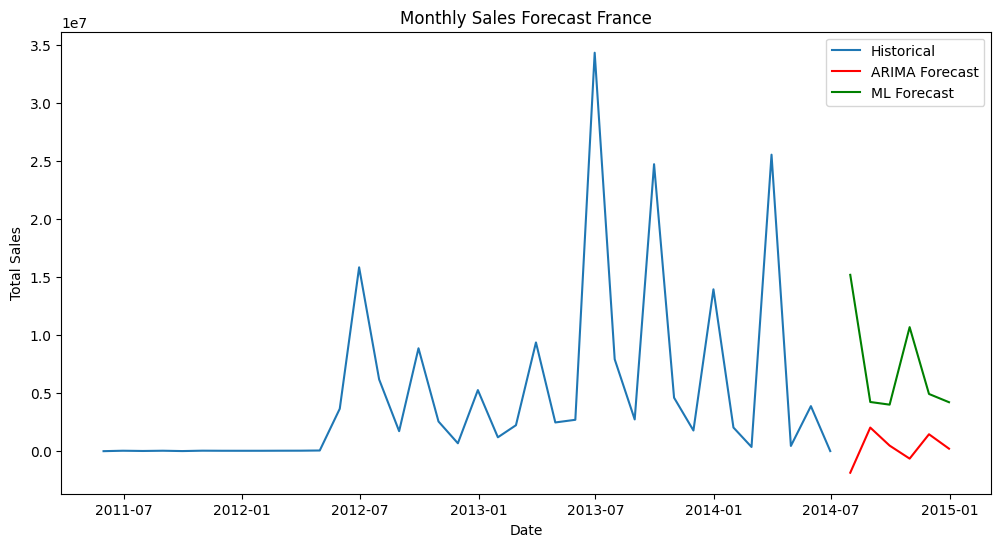

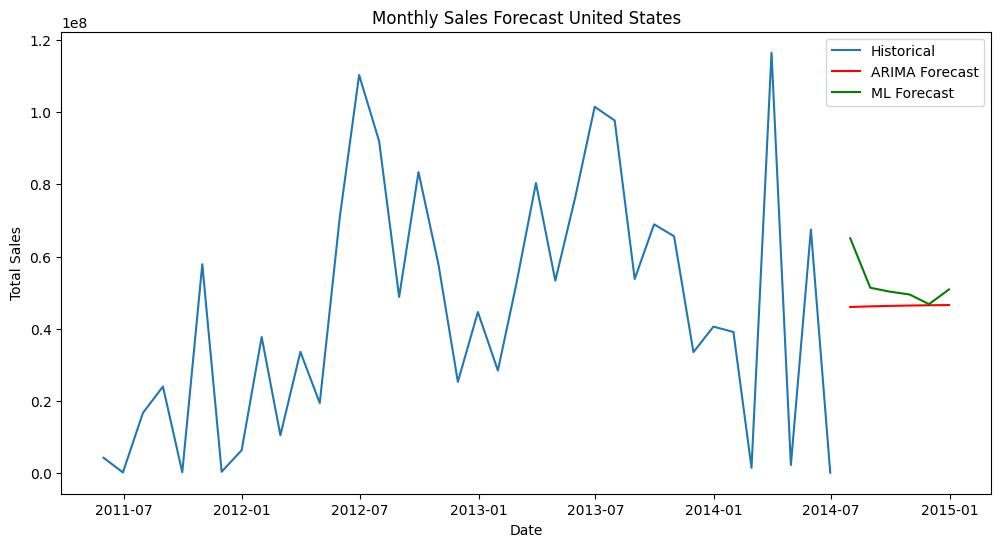

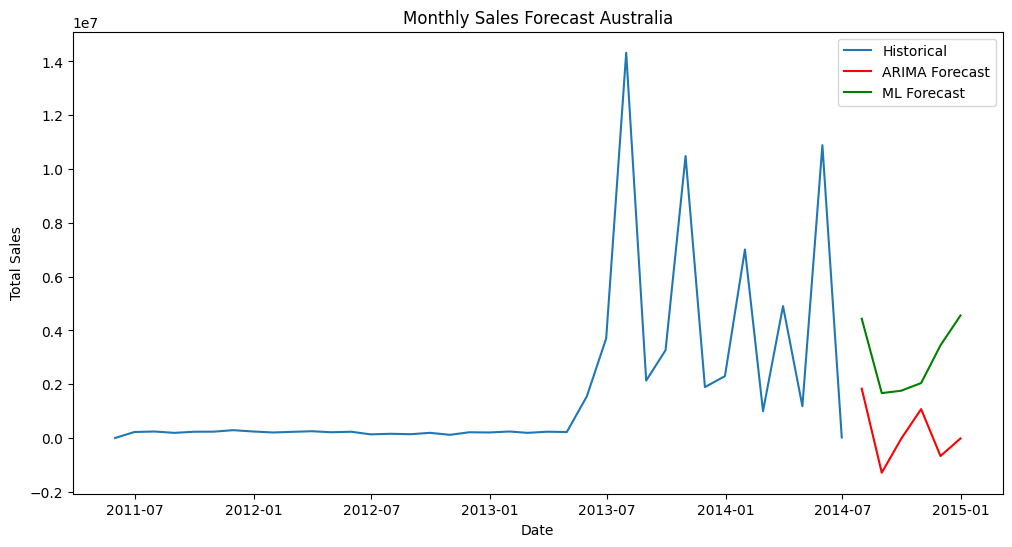

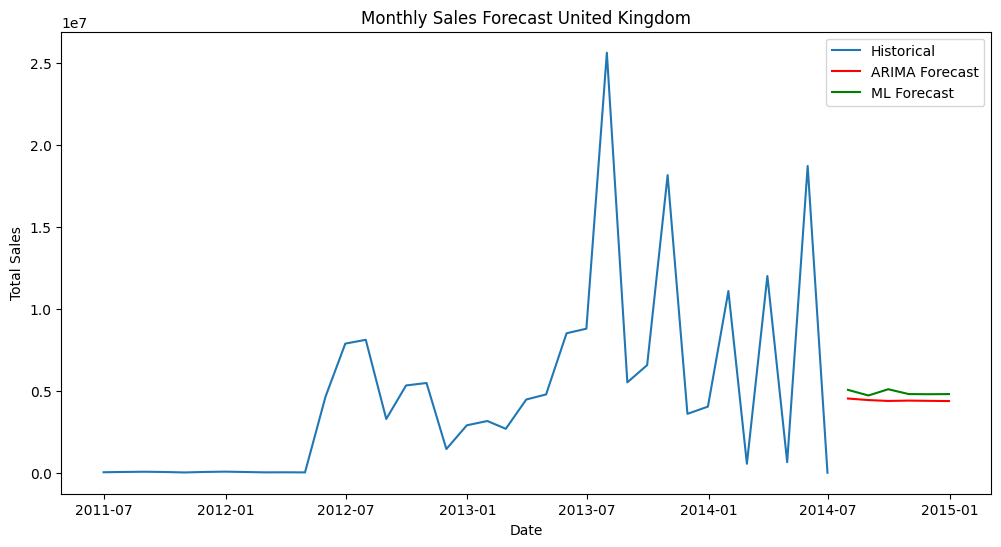

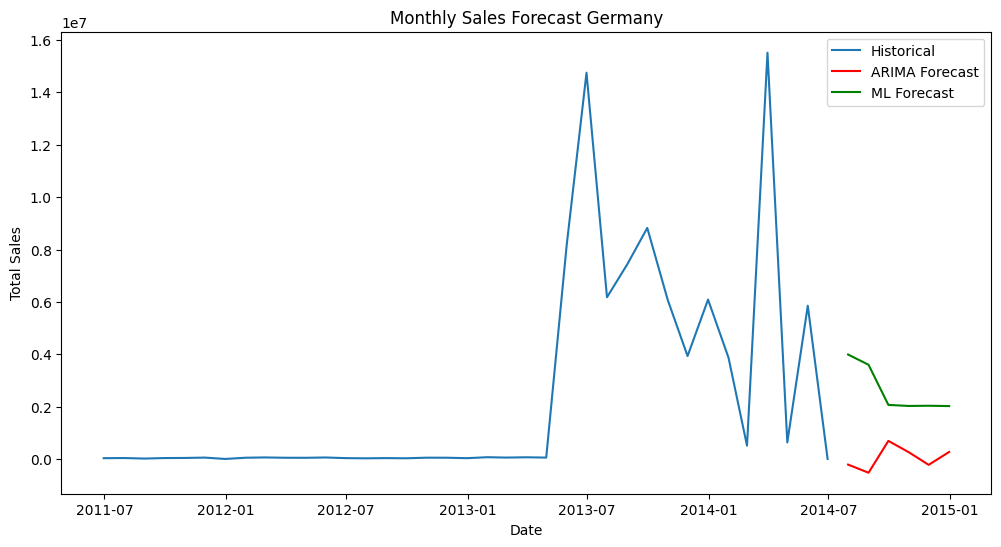

In [106]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[country], label='ML Forecast', color='green')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


## LSTM

In [107]:
def train_test_split_country_lstm(sales_data_country):
    combine_train_test = {
        country: data['TotalDue'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['TotalDue'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['TotalDue'].resample('ME').sum()[-9:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [108]:
# Resample 'TotalDue' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country_lstm(sales_data_country)

In [109]:
test_data

{'Canada': datetime
 2013-10-31    2.673192e+07
 2013-11-30    7.339794e+06
 2013-12-31    7.924098e+06
 2014-01-31    1.346066e+07
 2014-02-28    2.559653e+05
 2014-03-31    2.818234e+07
 2014-04-30    4.437361e+05
 2014-05-31    2.253944e+07
 2014-06-30    3.117614e+04
 Freq: ME, Name: TotalDue, dtype: float64,
 'France': datetime
 2013-10-31    4.605093e+06
 2013-11-30    1.782839e+06
 2013-12-31    1.393636e+07
 2014-01-31    2.037807e+06
 2014-02-28    3.638423e+05
 2014-03-31    2.552732e+07
 2014-04-30    4.535782e+05
 2014-05-31    3.881348e+06
 2014-06-30    1.078516e+04
 Freq: ME, Name: TotalDue, dtype: float64,
 'United States': datetime
 2013-10-31    6.561872e+07
 2013-11-30    3.347931e+07
 2013-12-31    4.055718e+07
 2014-01-31    3.907923e+07
 2014-02-28    1.396438e+06
 2014-03-31    1.164987e+08
 2014-04-30    2.188615e+06
 2014-05-31    6.748493e+07
 2014-06-30    5.493382e+04
 Freq: ME, Name: TotalDue, dtype: float64,
 'Australia': datetime
 2013-10-31    1.048613e+

In [110]:
def train_lstm_with_generator(data, look_back=3, batch_size=4, epochs=50):
    trained_models = {}
    scalers = {}

    for country, df in data.items():
        print(f"Training LSTM model for {country}...")

        # Scale sales data
        df = pd.Series.to_frame(df)
        scaler = MinMaxScaler(feature_range=(0, 1))
        sales_scaled = scaler.fit_transform(df)

        # Use TimeseriesGenerator to create input-output pairs
        generator = TimeseriesGenerator(sales_scaled, sales_scaled, length=look_back, batch_size=batch_size)

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))  # Input shape: (look_back, n_features=1)
        model.add(Dense(1))  # Predict the next step
        model.compile(optimizer='adam', loss='mse')

        # Train the model using generator
        model.fit(generator, epochs=epochs, verbose=1)

        # Save the model and scaler
        trained_models[country] = model
        scalers[country] = scaler

        print(f"{country} - Training completed.")

    return trained_models, scalers

In [111]:
lstm_models, lstm_scalers = train_lstm_with_generator(train_data, look_back=3)

Training LSTM model for Canada...
Epoch 1/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4390
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1492 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2932 
Epoch 4/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2592 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1983 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1611 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0909 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0851 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0500 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0568 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0517 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0526 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0773 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0704 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0512 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0835 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0392   
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0322     
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0583 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0594 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0274 
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0966

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0386 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0593 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0781 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0413 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0614 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0401 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0567 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0337 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0320 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0324 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0347 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0323 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0784 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3328
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1563 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1398 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2217 
Epoch 5/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1514 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1098 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0833 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0679 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0347 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0571 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0495 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0587 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0647 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0512 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0738 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0516 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0492 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0712 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0466 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0500
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0314     
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0219     
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0891 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 
Epoch 6/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0258 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0263 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0249     
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0273 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477     
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0366 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0402 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0774 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0543 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0260 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0517 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0784 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0526 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0358 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0805
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316     
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0799 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0983 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 
Epoch 6/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0061

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0624 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0257 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0511 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0412 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0280 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0646 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0618 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0369 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0617 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0470 
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0569   
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0915     
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0485     
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0612     
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0246 
Epoch 6/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0509 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0407 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0231 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0306 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0638 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0313 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0476 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0373 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0369 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0557 
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [112]:
def test_lstm_model(trained_models, scalers, test_data, look_back=3):
    predictions = {}

    for country, df in test_data.items():
        print(f"Testing LSTM model for {country}...")
        
        # Save the original index to align predictions later
        original_index = df.index

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[country]
        scaled_data = scaler.transform(df)

        # Ensure look_back does not exceed the available data length
        if len(scaled_data) <= look_back:
            print(f"Not enough data for {country}: reducing look_back to {len(scaled_data) - 1}")
            look_back = len(scaled_data) - 1

        # Prepare input sequences using TimeseriesGenerator
        generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)

        # Get the trained model
        model = trained_models[country]

        # Make predictions
        y_pred_scaled = []
        for i in range(len(generator)):
            X, _ = generator[i]  # Get input sequence
            y_pred = model.predict(X, verbose=0)  # Predict next step
            y_pred_scaled.append(y_pred[0][0])  # Append prediction

        # Inverse transform predictions back to original scale
        y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).ravel()

        # Align predictions with the correct index
        prediction_index = original_index[-len(y_pred):]
        predictions[country] = pd.Series(y_pred, index=prediction_index)

        print(f"{country} - Testing completed.")

    return predictions


In [113]:
lstm_res = test_lstm_model(lstm_models, lstm_scalers, test_data)

Testing LSTM model for Canada...
Canada - Testing completed.
Testing LSTM model for France...
France - Testing completed.
Testing LSTM model for United States...
United States - Testing completed.
Testing LSTM model for Australia...
Australia - Testing completed.
Testing LSTM model for United Kingdom...
United Kingdom - Testing completed.
Testing LSTM model for Germany...
Germany - Testing completed.


In [119]:
lstm_res

{'Canada': datetime
 2014-01-31    14177313.0
 2014-02-28    11756906.0
 2014-03-31    10731233.0
 2014-04-30    13727771.0
 2014-05-31    11622348.0
 2014-06-30    15635042.0
 Freq: ME, dtype: float32,
 'France': datetime
 2014-01-31     5205773.50
 2014-02-28     5964562.00
 2014-03-31     9107359.00
 2014-04-30     3718591.25
 2014-05-31     6986146.50
 2014-06-30    12932338.00
 Freq: ME, dtype: float32,
 'United States': datetime
 2014-01-31    46902076.0
 2014-02-28    43081252.0
 2014-03-31    37073784.0
 2014-04-30    49640060.0
 2014-05-31    42147740.0
 2014-06-30    54190708.0
 Freq: ME, dtype: float32,
 'Australia': datetime
 2014-01-31    4160929.50
 2014-02-28    2700194.75
 2014-03-31    2707449.75
 2014-04-30    3490519.50
 2014-05-31    2104616.25
 2014-06-30    3486823.50
 Freq: ME, dtype: float32,
 'United Kingdom': datetime
 2014-01-31    8370231.0
 2014-02-28    5656181.0
 2014-03-31    5372021.5
 2014-04-30    6970528.0
 2014-05-31    4614769.0
 2014-06-30    8015

In [114]:
def forecast_lstm_model(trained_models, scalers, test_data, look_back=3, forecast_steps=6):
    forecasts = {}

    for country, df in test_data.items():
        print(f"Forecasting next {forecast_steps} months for {country}...")

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[country]
        scaled_data = scaler.transform(df)

        # Start with the last look_back window of scaled data
        last_window = scaled_data[-look_back:].reshape(1, look_back, 1)

        # Initialize list to store predictions
        forecast_scaled = []

        # Get the trained model
        model = trained_models[country]

        # Iteratively predict the next steps
        for step in range(forecast_steps):
            # Predict next value
            next_pred = model.predict(last_window, verbose=0)[0][0]
            forecast_scaled.append(next_pred)

            # Update the input window: remove oldest value, append predicted value
            last_window = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)

        # Inverse transform predictions back to original scale
        forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).ravel()

        # Create a date range for the forecast period
        start_date = df.index[-1]  # Last date in the test data
        forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

        # Store forecast as a Pandas Series
        forecasts[country] = pd.Series(forecast, index=forecast_index)

        print(f"{country} - Forecasting completed.")

    return forecasts


In [115]:
forecast_lstms = forecast_lstm_model(lstm_models, lstm_scalers, test_data)

Forecasting next 6 months for Canada...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Canada - Forecasting completed.
Forecasting next 6 months for France...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


France - Forecasting completed.
Forecasting next 6 months for United States...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


United States - Forecasting completed.
Forecasting next 6 months for Australia...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Australia - Forecasting completed.
Forecasting next 6 months for United Kingdom...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


United Kingdom - Forecasting completed.
Forecasting next 6 months for Germany...
Germany - Forecasting completed.


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


In [116]:
forecast_lstms

{'Canada': 2014-07-31    10737663.0
 2014-08-31    12565394.0
 2014-09-30    10737168.0
 2014-10-31    12603454.0
 2014-11-30    12902665.0
 2014-12-31    12949413.0
 Freq: ME, dtype: float32,
 'France': 2014-07-31    2574084.75
 2014-08-31    3692057.25
 2014-09-30    2341307.00
 2014-10-31    4114265.75
 2014-11-30    4559018.00
 2014-12-31    4368716.00
 Freq: ME, dtype: float32,
 'United States': 2014-07-31    34341128.0
 2014-08-31    39108996.0
 2014-09-30    35531904.0
 2014-10-31    42264404.0
 2014-11-30    43518024.0
 2014-12-31    44586456.0
 Freq: ME, dtype: float32,
 'Australia': 2014-07-31    2868368.00
 2014-08-31    3926533.75
 2014-09-30    2158515.00
 2014-10-31    2637154.00
 2014-11-30    2640570.25
 2014-12-31    2345319.25
 Freq: ME, dtype: float32,
 'United Kingdom': 2014-07-31    5824251.0
 2014-08-31    7970130.5
 2014-09-30    4723371.0
 2014-10-31    6146690.0
 2014-11-30    6243930.0
 2014-12-31    5729336.0
 Freq: ME, dtype: float32,
 'Germany': 2014-07-31 

In [205]:
# Initialize a dictionary to store MSE for each forecast method
rmse_results = {}

# Directory to save figures
output_dir = "results\\countries\\test"
os.makedirs(output_dir, exist_ok=True)

for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]
    
    # Actual data (test data for evaluation)
    actual = combined_data[country][-len(forecast_series):]  # Align test period with forecast

    # Forecasts
    arima_forecast = forecast_series
    ml_forecast = countries_predict[country]
    lstm_forecast = lstm_res[country]

    # Calculate MSE for each method
    rmse_arima = root_mean_squared_error(actual, arima_forecast)
    rmse_ml = root_mean_squared_error(actual, ml_forecast)
    rmse_lstm = root_mean_squared_error(actual, lstm_forecast)

    # Store MSE in dictionary
    rmse_results[country] = {
        'ARIMA': rmse_arima,
        'ML': rmse_ml,
        'LSTM': rmse_lstm
    }
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(countries_predict[country], label='ML Forecast', color='green')
    plt.plot(lstm_res[country], label='LSTM Forecast', color='black')

    # Add MSE as text box (top-left)
    mse_text = (f"ARIMA MSE: {rmse_arima:.2e}\n"
                f"ML MSE: {rmse_ml:.2e}\n"
                f"LSTM MSE: {rmse_lstm:.2e}")
    plt.text(0.02, 0.85, mse_text, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))

    # Add the legend at the bottom
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, 0.8))  # Position legend below MSE box

    # Add labels and title
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')

    # Save the plot
    figure_path = os.path.join(output_dir, f"{country}_forecast.png")
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to save memory
    
    print(f"Saved plot for {country} at: {figure_path}")

# Display the MSE results
for country, errors in rmse_results.items():
    print(f"\n--- {country} ---")
    for method, rmse in errors.items():
        print(f"{method} RMSE: {rmse:.2e}")


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Canada at: results\countries\test\Canada_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for France at: results\countries\test\France_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for United States at: results\countries\test\United States_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Australia at: results\countries\test\Australia_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for United Kingdom at: results\countries\test\United Kingdom_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Germany at: results\countries\test\Germany_forecast.png

--- Canada ---
ARIMA RMSE: 1.37e+07
ML RMSE: 1.22e+07
LSTM RMSE: 1.28e+07

--- France ---
ARIMA RMSE: 7.42e+06
ML RMSE: 9.41e+06
LSTM RMSE: 9.11e+06

--- United States ---
ARIMA RMSE: 4.36e+07
ML RMSE: 5.26e+07
LSTM RMSE: 4.82e+07

--- Australia ---
ARIMA RMSE: 4.11e+06
ML RMSE: 5.05e+06
LSTM RMSE: 4.29e+06

--- United Kingdom ---
ARIMA RMSE: 7.35e+06
ML RMSE: 7.58e+06
LSTM RMSE: 7.97e+06

--- Germany ---
ARIMA RMSE: 5.35e+06
ML RMSE: 6.21e+06
LSTM RMSE: 6.23e+06


In [210]:
# Function to calculate confidence intervals
def calculate_conf_level(series, alpha):
    n = len(series)
    mean = series.mean()
    std = series.std(ddof=1)
    t_critical = t.ppf(1 - alpha / 2, df=n - 1)
    margin_of_error = t_critical * (std / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error

In [211]:
calculate_conf_level(future_forecasts['Canada'], 0.05)

(13095151.72340651, 15178277.871431293)

In [212]:
# Directory to save plots
output_dir = "results\\countries\\forecast"
os.makedirs(output_dir, exist_ok=True)

# Dictionary to store forecasts and confidence intervals
lower_bounds = {}
upper_bounds = {}

# Loop through each country and plot forecasts
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Calculate confidence intervals for each forecast method
    arima_conf = calculate_conf_level(forecast_series, 0.05)
    ml_conf = calculate_conf_level(future_forecasts[country], 0.05)
    lstm_conf = calculate_conf_level(forecast_lstms[country], 0.05)

    lower_bounds[country] = {
        'ARIMA': arima_conf[0],
        'ML': ml_conf[0],
        'LSTM': lstm_conf[0]
    }
    
    upper_bounds[country] = {
        'ARIMA': arima_conf[1],
        'ML': ml_conf[1],
        'LSTM': lstm_conf[1]
    }
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[country], label='ML Forecast', color='green')
    plt.plot(forecast_lstms[country], label='LSTM Forecast', color='black')

    # Add confidence intervals as shaded regions
    plt.fill_between(forecast_series.index, lower_bounds[country]['ARIMA'], upper_bounds[country]['ARIMA'], 
                     color='red', alpha=0.2, label='ARIMA CI')
    plt.fill_between(future_forecasts[country].index, lower_bounds[country]['ML'], upper_bounds[country]['ML'], 
                     color='green', alpha=0.2, label='ML CI')
    plt.fill_between(forecast_lstms[country].index, lower_bounds[country]['LSTM'], upper_bounds[country]['LSTM'], 
                     color='black', alpha=0.2, label='LSTM CI')

    # Add titles and labels
    plt.title(f'Monthly Sales Forecast for {country}')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, f"{country}_forecast.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to save memory
    
    print(f"Saved plot for {country} at: {plot_path}")

C:\Users\Hi There\AppData\Local\Temp\ipykernel_29312\488416027.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Canada at: results\countries\forecast\Canada_forecast.png
Saved plot for France at: results\countries\forecast\France_forecast.png
Saved plot for United States at: results\countries\forecast\United States_forecast.png
Saved plot for Australia at: results\countries\forecast\Australia_forecast.png
Saved plot for United Kingdom at: results\countries\forecast\United Kingdom_forecast.png
Saved plot for Germany at: results\countries\forecast\Germany_forecast.png


In [213]:
lower_bounds['Canada']

{'ARIMA': 10270543.46041543,
 'ML': 13095151.72340651,
 'LSTM': 10977247.520294622}